In [2]:
from os.path import abspath, expanduser

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter


import numpy as np
import pandas as pd
import rasters as rt

from ECOv002_CMR import ECOSTRESS_CMR_search, download_file, GranuleID, download_ECOSTRESS_granule
from ECOv002_granules import ET_COLORMAP, NDVI_COLORMAP

from PTJPL import PTJPL, load_fAPARmax, load_Topt

%matplotlib inline

In [3]:
import logging

logging.getLogger().handlers = []

In [4]:
aquisition_date = "2024-10-22"
orbit = 35698
scene = 14
tile = "11SPS"
ECOSTRESS_download_directory = "~/Documents/ECOSTRESS/ET_sensitivity"
static_directory = "~/Documents/ECOSTRESS/ET_sensitivity"
working_directory = "~/Documents/ECOSTRESS/ET_sensitivity"

In [5]:
error_cmap = LinearSegmentedColormap.from_list("error", ["blue", "white", "red"])

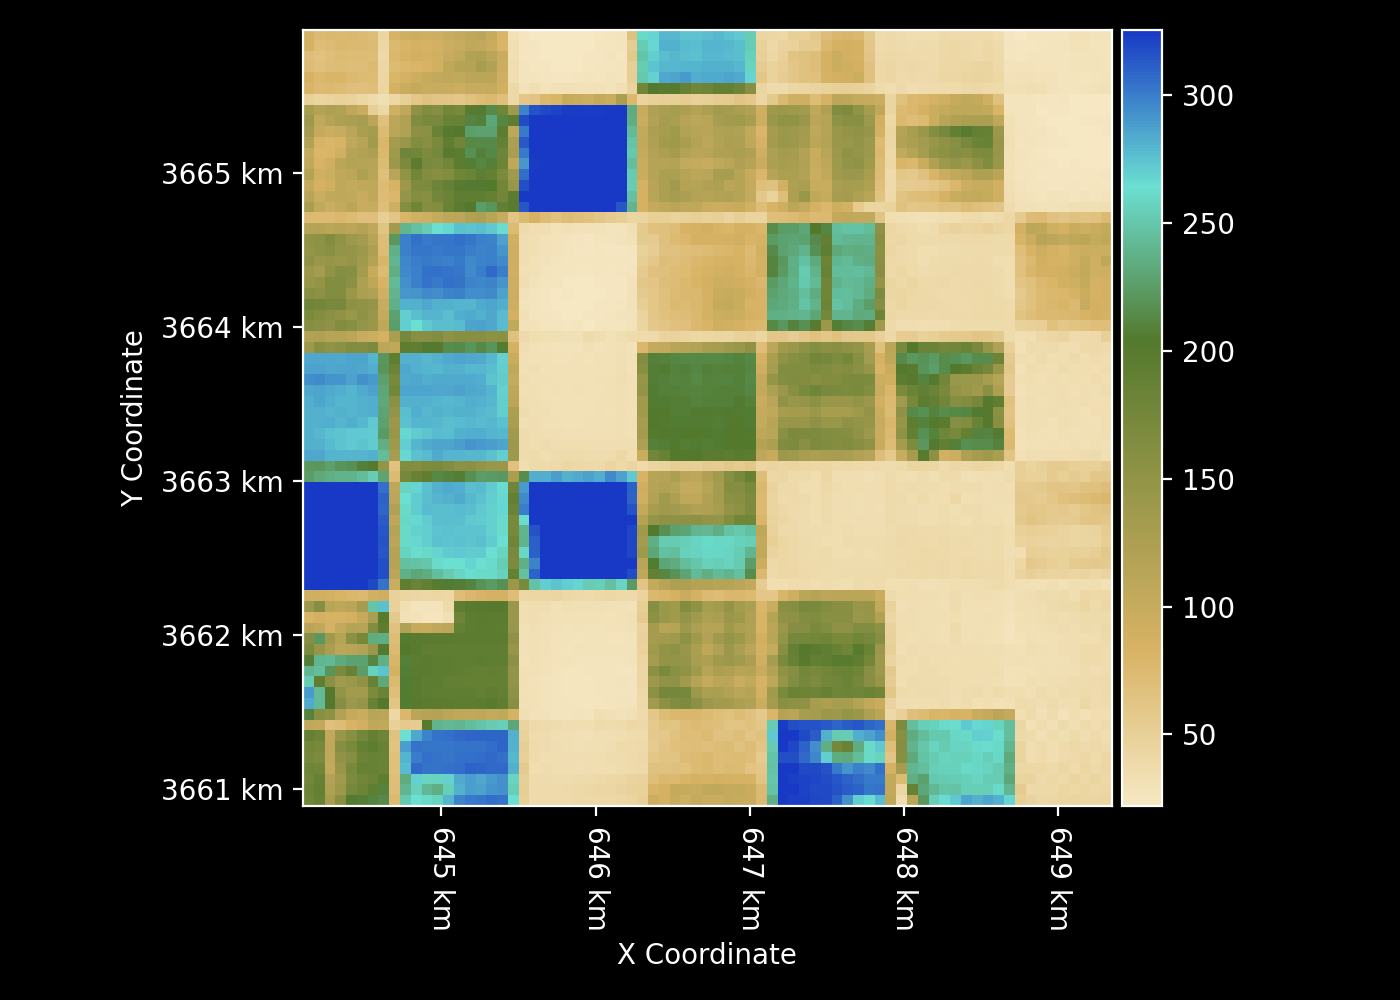

In [6]:
subset = rt.Raster.open("farms_subset.tif")
subset.cmap = ET_COLORMAP
subset

In [7]:
geometry = subset.geometry
geometry

{
  "dimensions": {
    "rows": 72,
    "cols": 75
  },
  "bbox": {
    "xmin": 644100.0,
    "ymin": 3660890.0,
    "xmax": 649350.0,
    "ymax": 3665930.0
  },
  "crs": "EPSG:32611",
  "resolution": {
    "cell_width": 70.0,
    "cell_height": -70.0
  }
}

In [8]:
L2T_LSTE_granule = download_ECOSTRESS_granule(
    product="L2T_LSTE", 
    orbit=orbit,
    scene=scene,
    tile=tile, 
    aquisition_date=aquisition_date,
    parent_directory=ECOSTRESS_download_directory
)

L2T_LSTE_granule

L2TLSTE("/Users/Maggiej/Documents/ECOSTRESS/ET_sensitivity/ECOv002_L2T_LSTE_35698_014_11SPS_20241022T183627_0713_01")

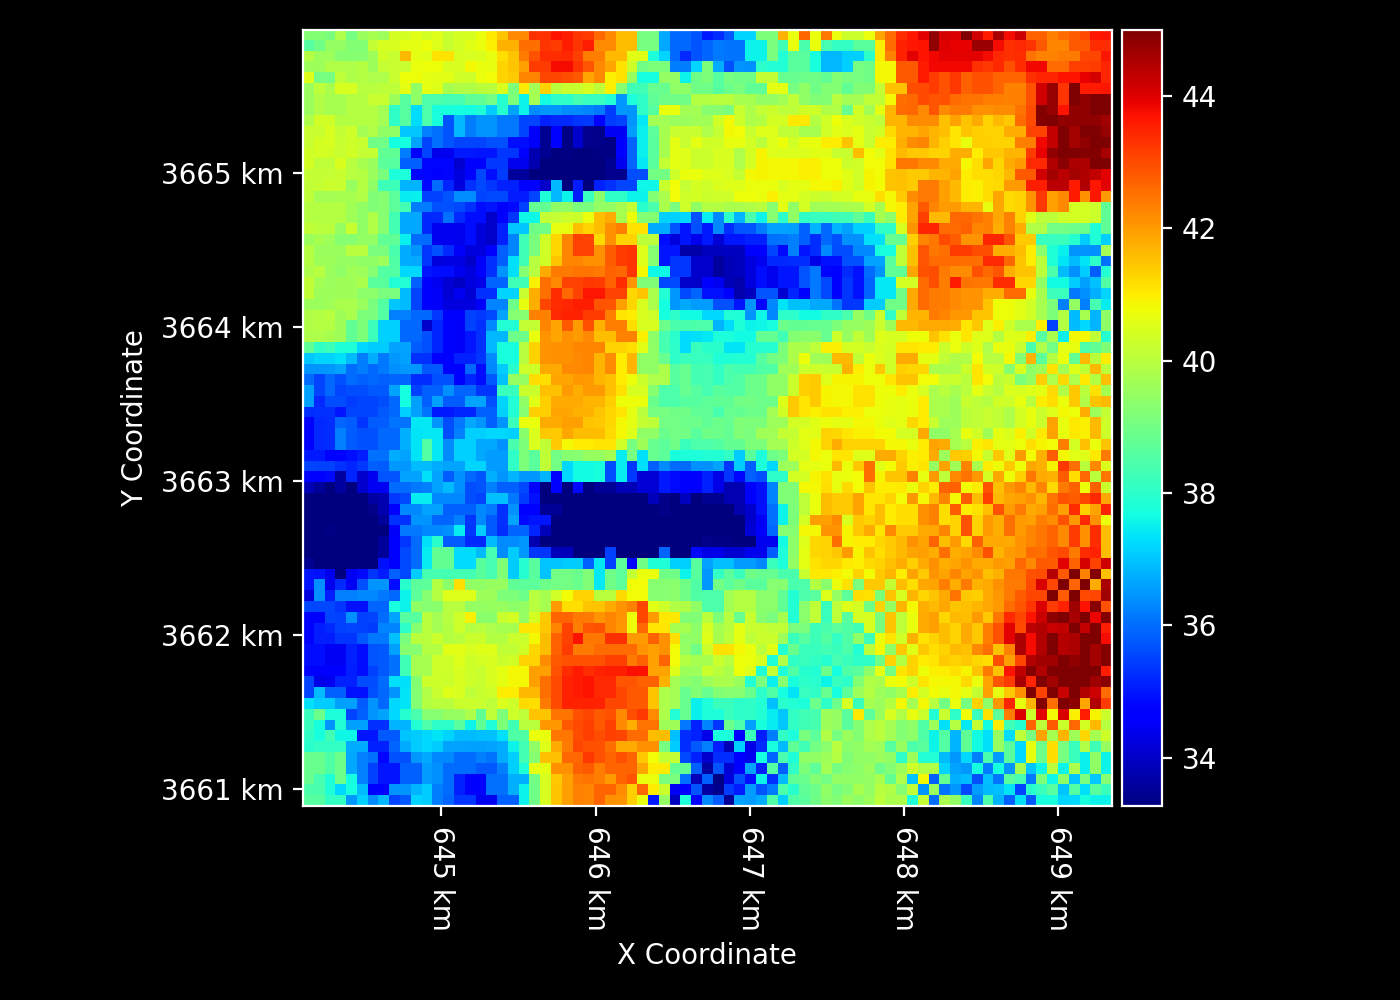

In [9]:
ST_C = L2T_LSTE_granule.ST_C.to_geometry(geometry)
ST_C

In [10]:
L2T_STARS_granule = download_ECOSTRESS_granule(
    product="L2T_STARS", 
    tile=tile, 
    aquisition_date=aquisition_date,
    parent_directory=ECOSTRESS_download_directory
)

L2T_STARS_granule

L2TSTARS("/Users/Maggiej/Documents/ECOSTRESS/ET_sensitivity/ECOv002_L2T_STARS_11SPS_20241022_0713_01")

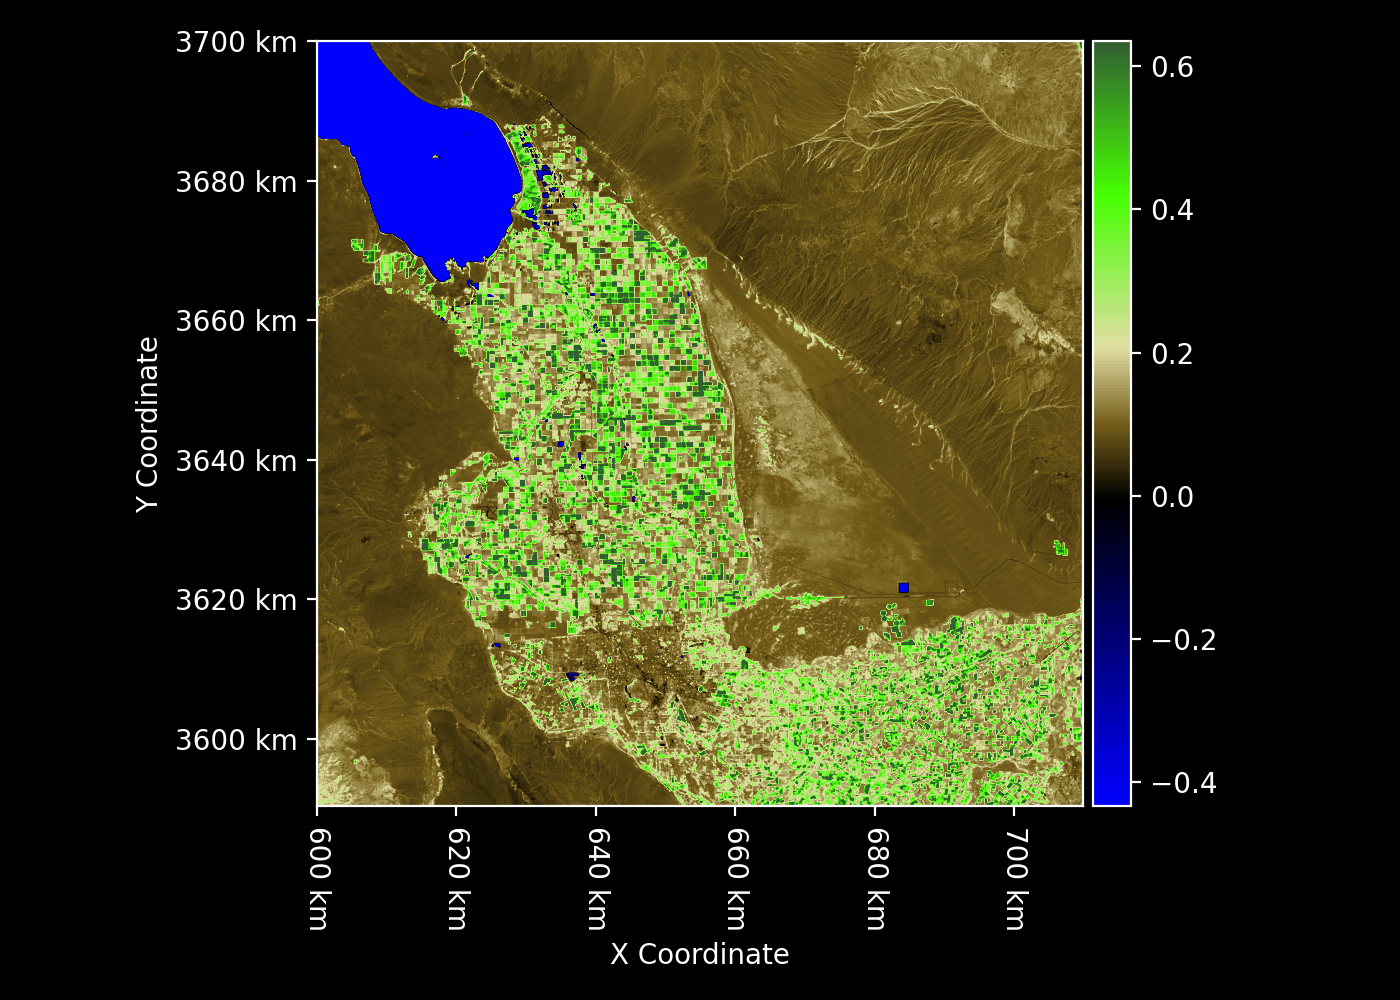

In [11]:
NDVI_tile = L2T_STARS_granule.NDVI
NDVI_tile

In [12]:
tile_geometry = NDVI_tile.geometry
tile_geometry

{
  "dimensions": {
    "rows": 1568,
    "cols": 1568
  },
  "bbox": {
    "xmin": 600000.0,
    "ymin": 3590260.0,
    "xmax": 709760.0,
    "ymax": 3700020.0
  },
  "crs": "EPSG:32611",
  "resolution": {
    "cell_width": 70.0,
    "cell_height": -70.0
  }
}

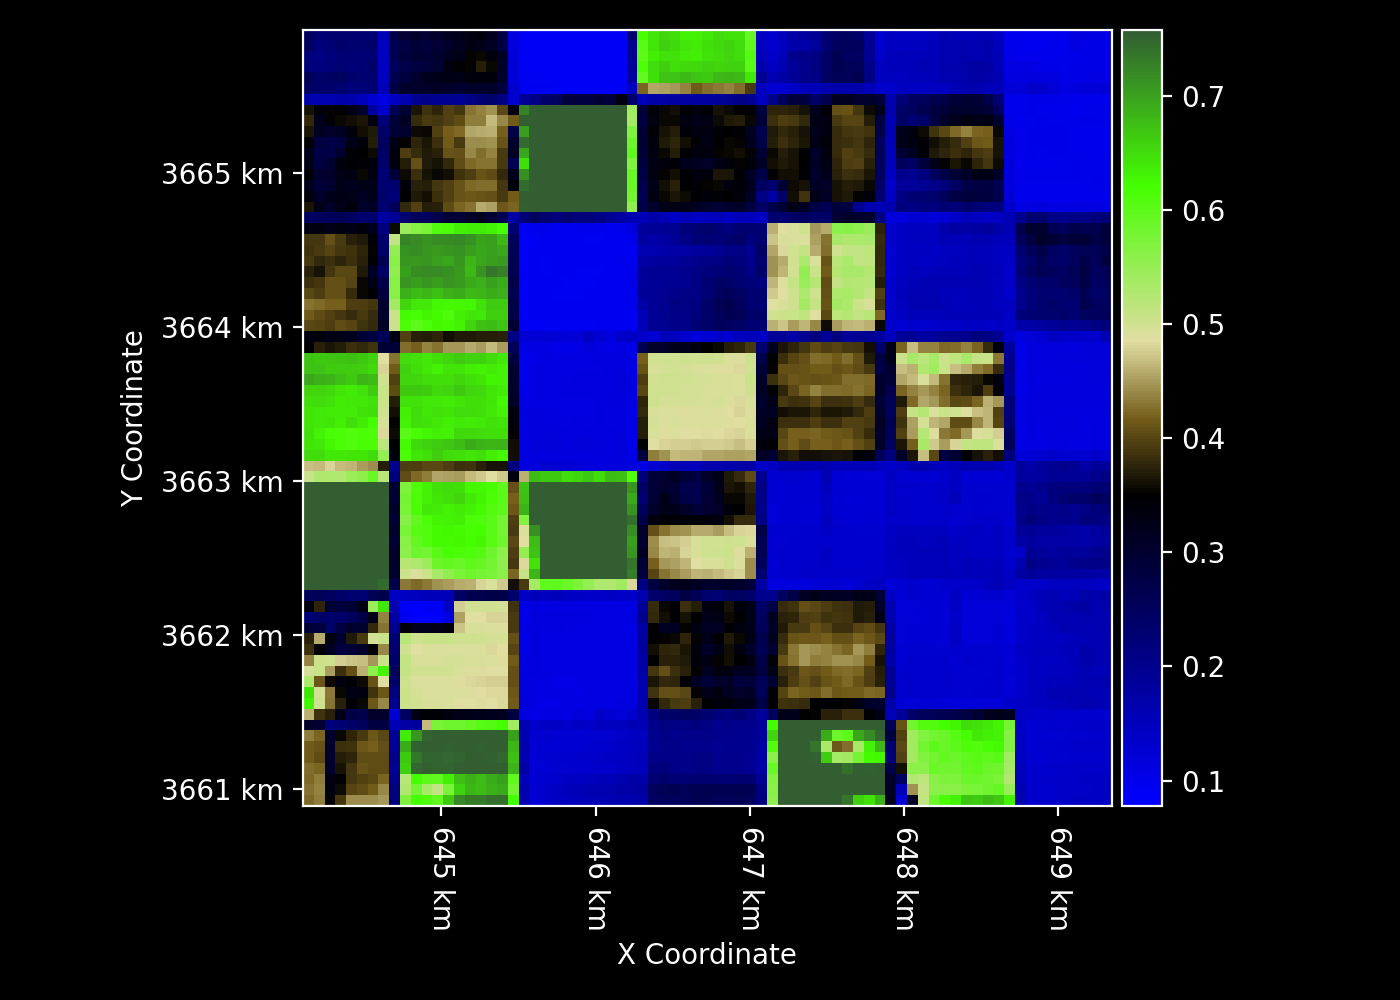

In [13]:
NDVI = NDVI_tile.to_geometry(geometry)
NDVI

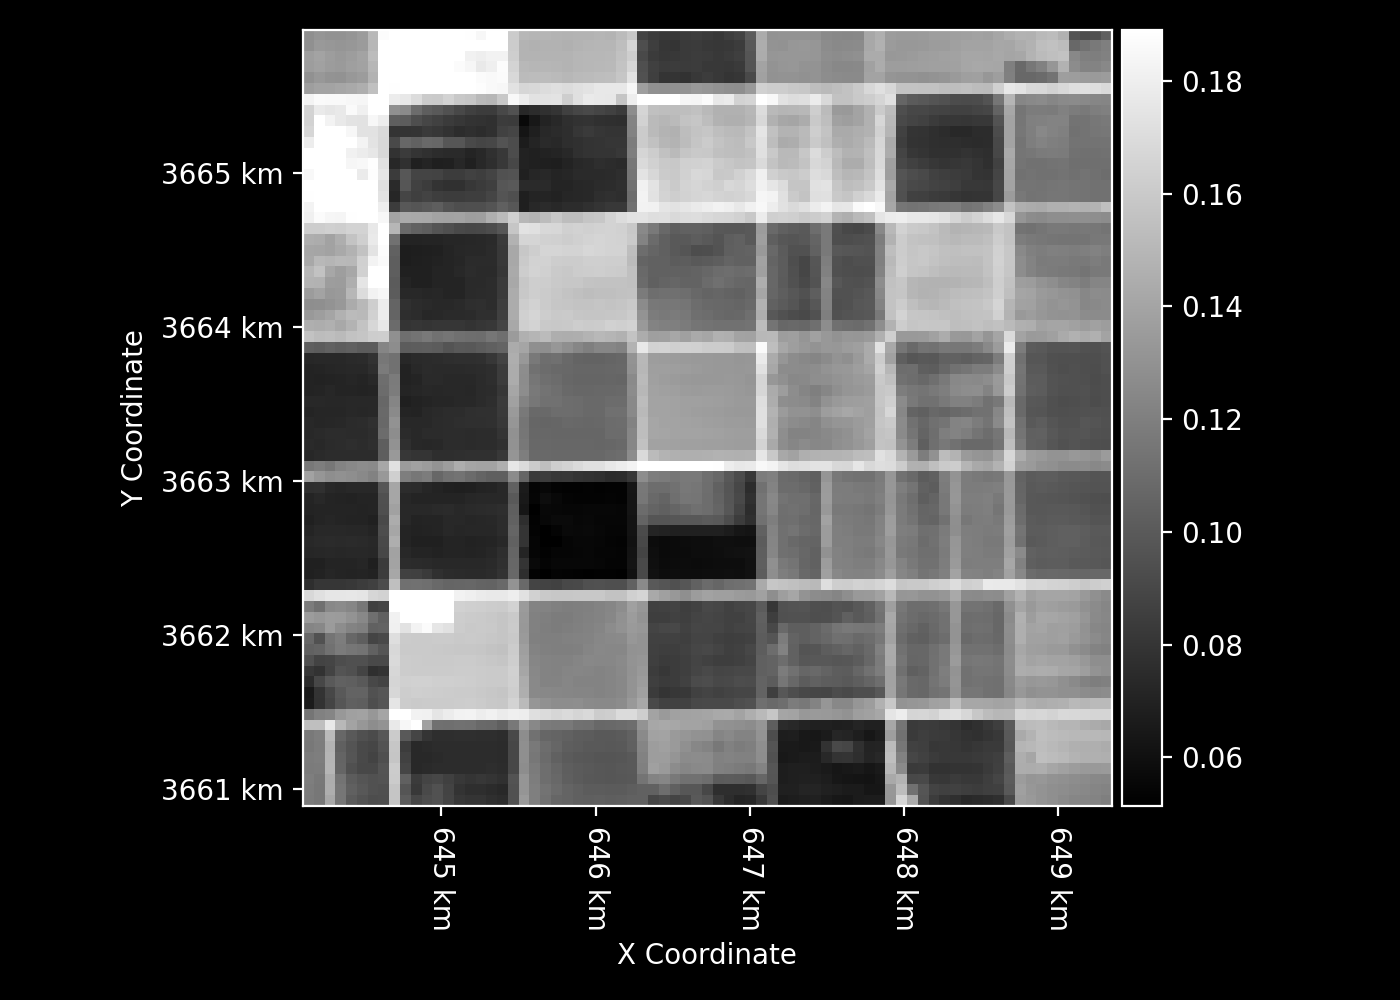

In [14]:
albedo = L2T_STARS_granule.albedo.to_geometry(geometry)
albedo

In [15]:
L3T_SEB_granule = download_ECOSTRESS_granule(
    product="L3T_SEB", 
    orbit=orbit,
    scene=scene,
    tile=tile, 
    aquisition_date=aquisition_date,
    parent_directory=ECOSTRESS_download_directory
)

L3T_SEB_granule

L3TSEB("/Users/Maggiej/Documents/ECOSTRESS/ET_sensitivity/ECOv002_L3T_SEB_35698_014_11SPS_20241022T183627_0713_01")

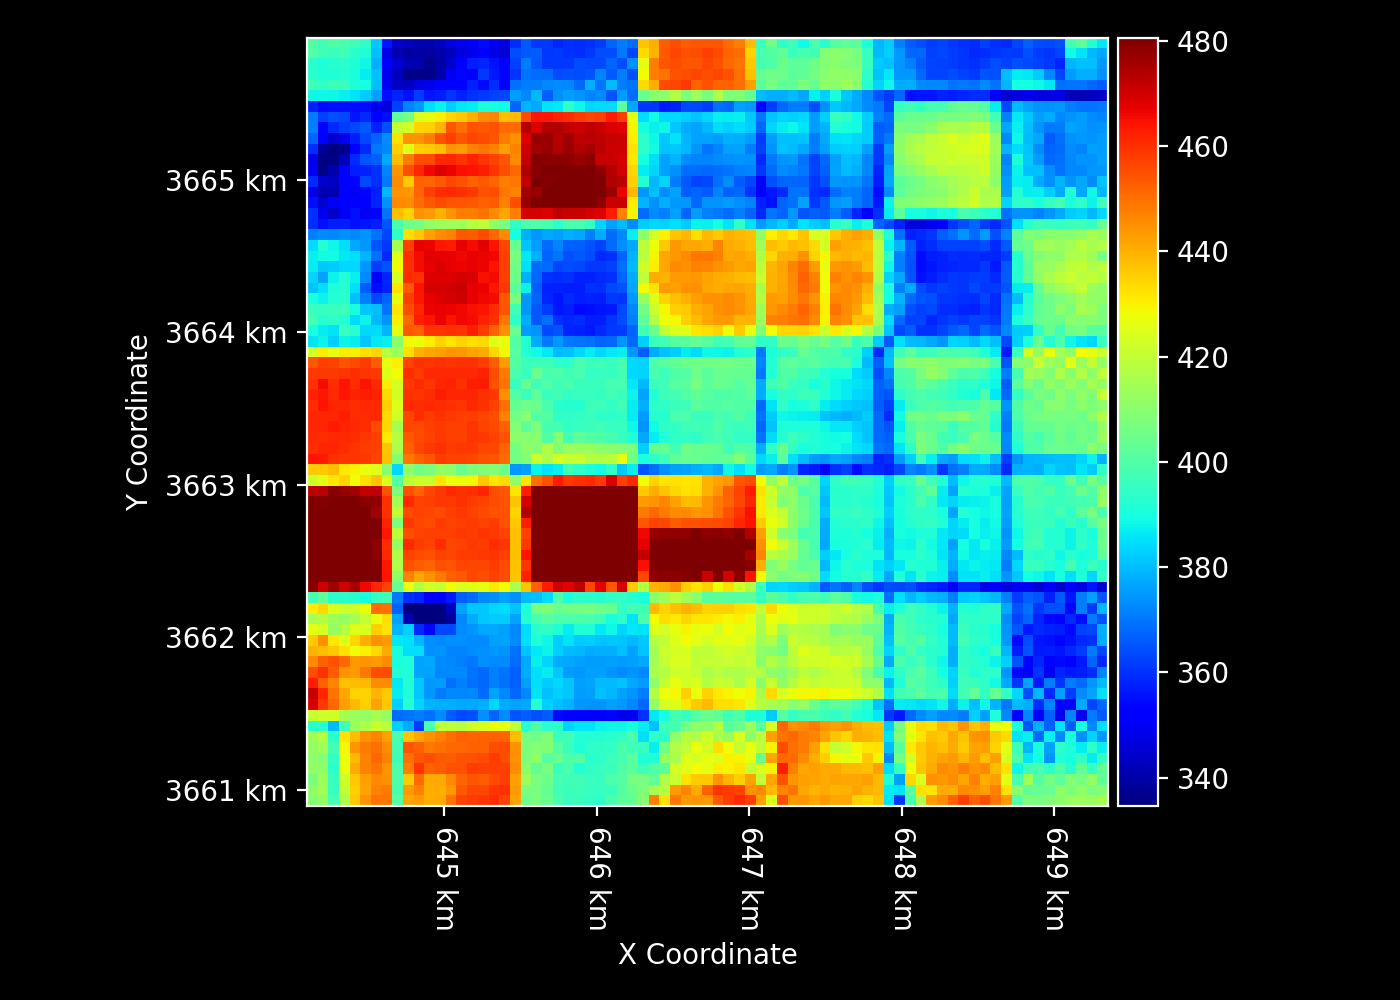

In [16]:
Rn = L3T_SEB_granule.variable("Rn").to_geometry(geometry)
Rn

In [17]:
L3T_MET_granule = download_ECOSTRESS_granule(
    product="L3T_MET", 
    orbit=orbit,
    scene=scene,
    tile=tile, 
    aquisition_date=aquisition_date,
    parent_directory=ECOSTRESS_download_directory
)

L3T_MET_granule

L3TMET("/Users/Maggiej/Documents/ECOSTRESS/ET_sensitivity/ECOv002_L3T_MET_35698_014_11SPS_20241022T183627_0713_01")

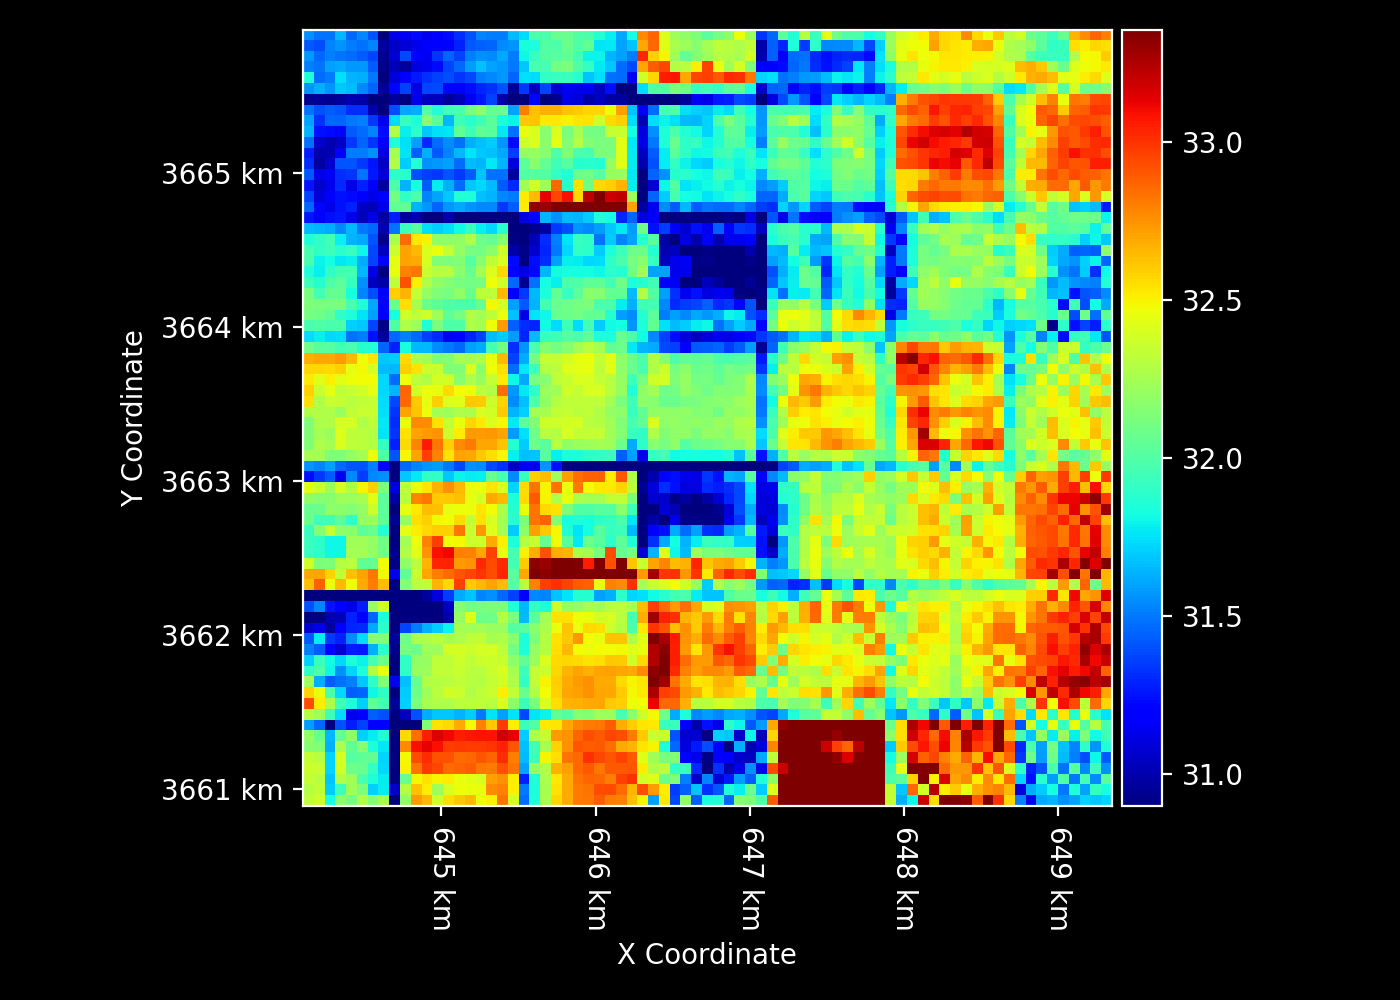

In [18]:
Ta_C = L3T_MET_granule.variable("Ta").to_geometry(geometry)
Ta_C

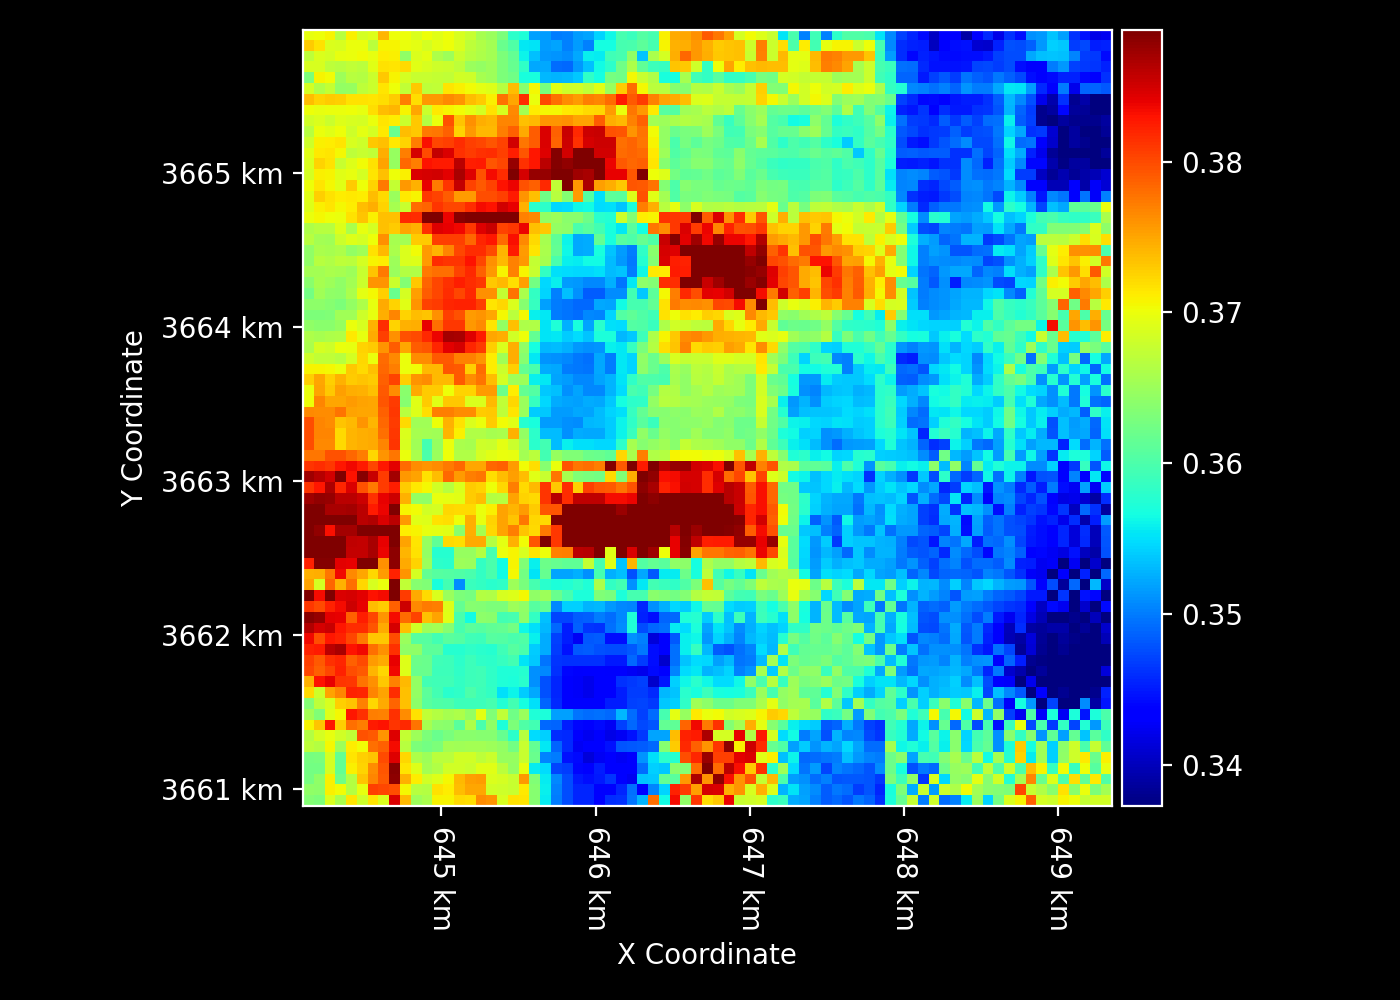

In [19]:
RH = L3T_MET_granule.variable("RH").to_geometry(geometry)
RH

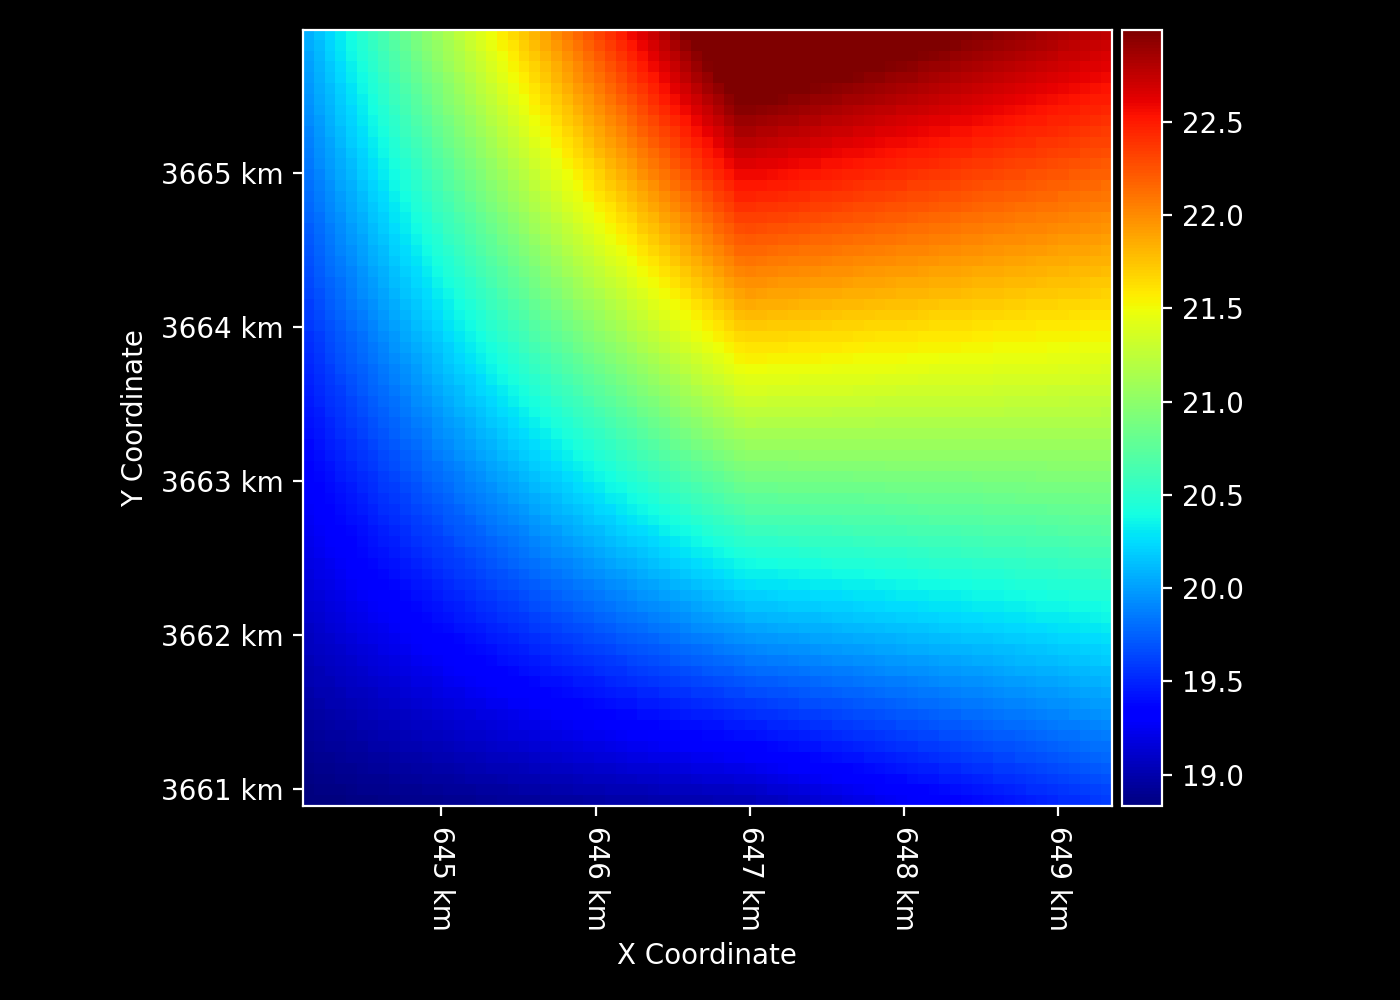

In [20]:
Topt = load_Topt(geometry)
Topt

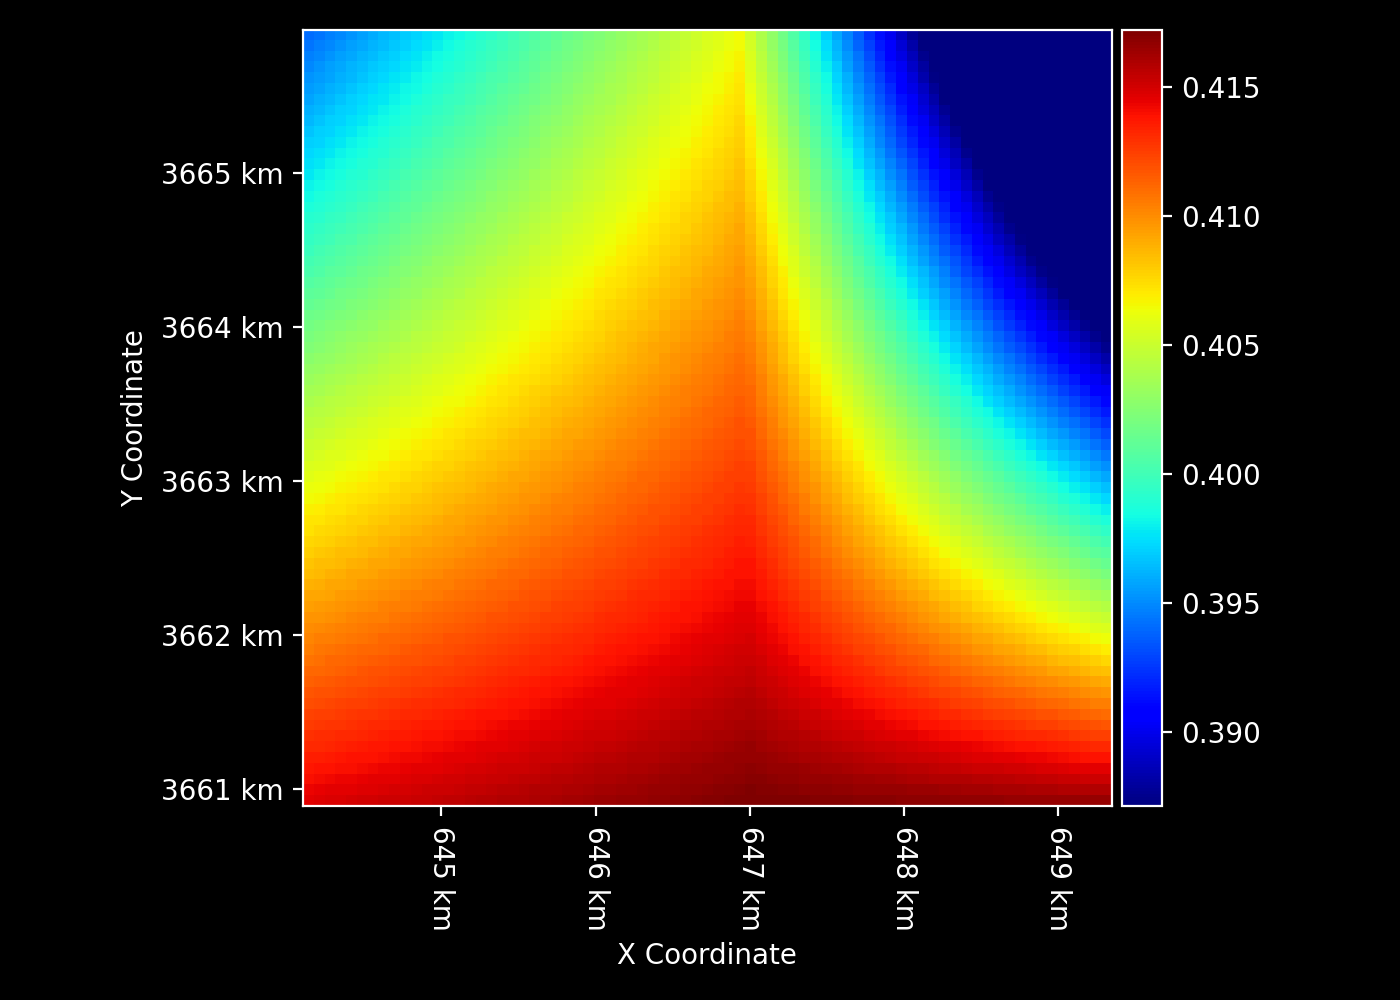

In [21]:
fAPARmax = load_fAPARmax(geometry)
fAPARmax

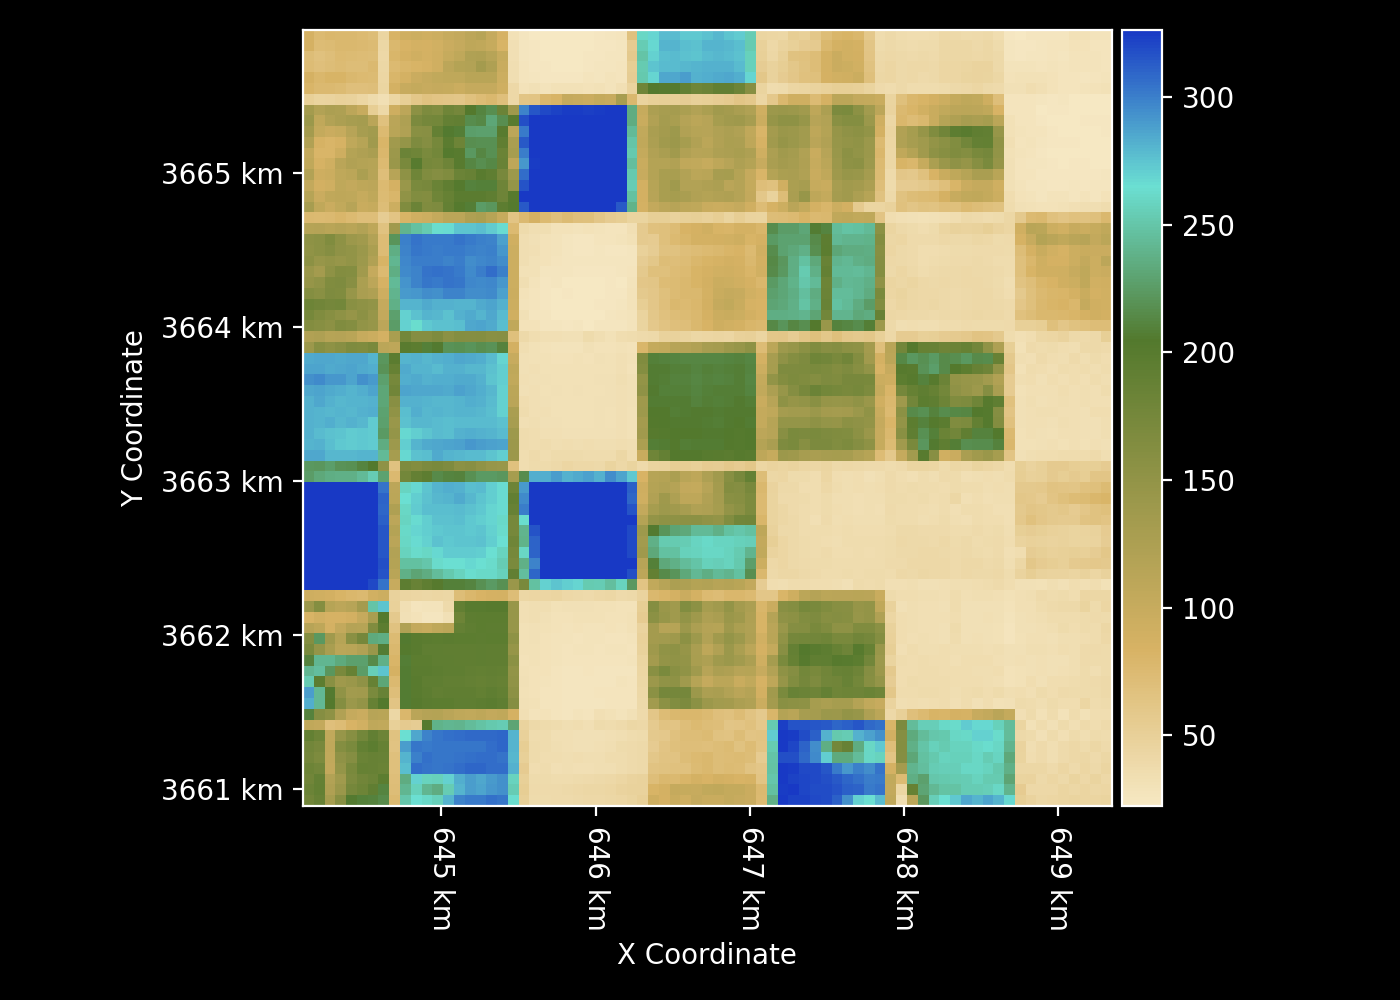

In [22]:
results = PTJPL(
    NDVI=NDVI,
    Ta_C=Ta_C,
    RH=RH,
    Rn=Rn,
    albedo=albedo,
    ST_C=ST_C
)

LE = results["LE"]
LE.cmap = ET_COLORMAP
LE

In [27]:
shifted_tile_geometry = tile_geometry.shift_distance(70, 45)
shifted_tile_geometry


{
  "dimensions": {
    "rows": 1568,
    "cols": 1568
  },
  "bbox": {
    "xmin": 600049.4974746831,
    "ymin": 3590210.502525317,
    "xmax": 709809.4974746831,
    "ymax": 3699970.502525317
  },
  "crs": "EPSG:32611",
  "resolution": {
    "cell_width": 70.0,
    "cell_height": -70.0
  }
}

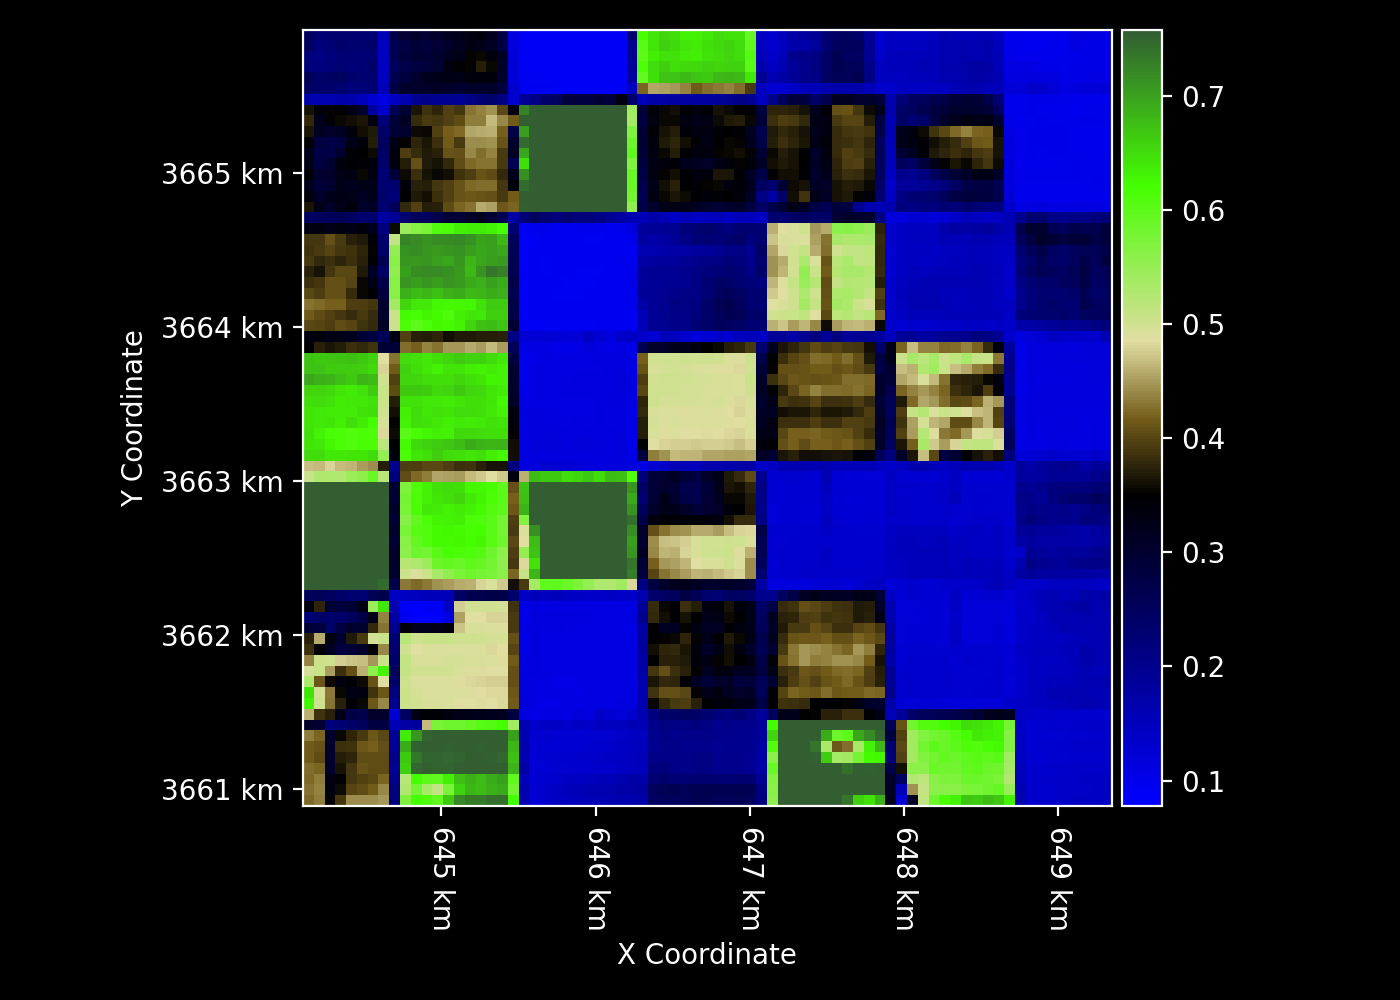

In [28]:
NDVI

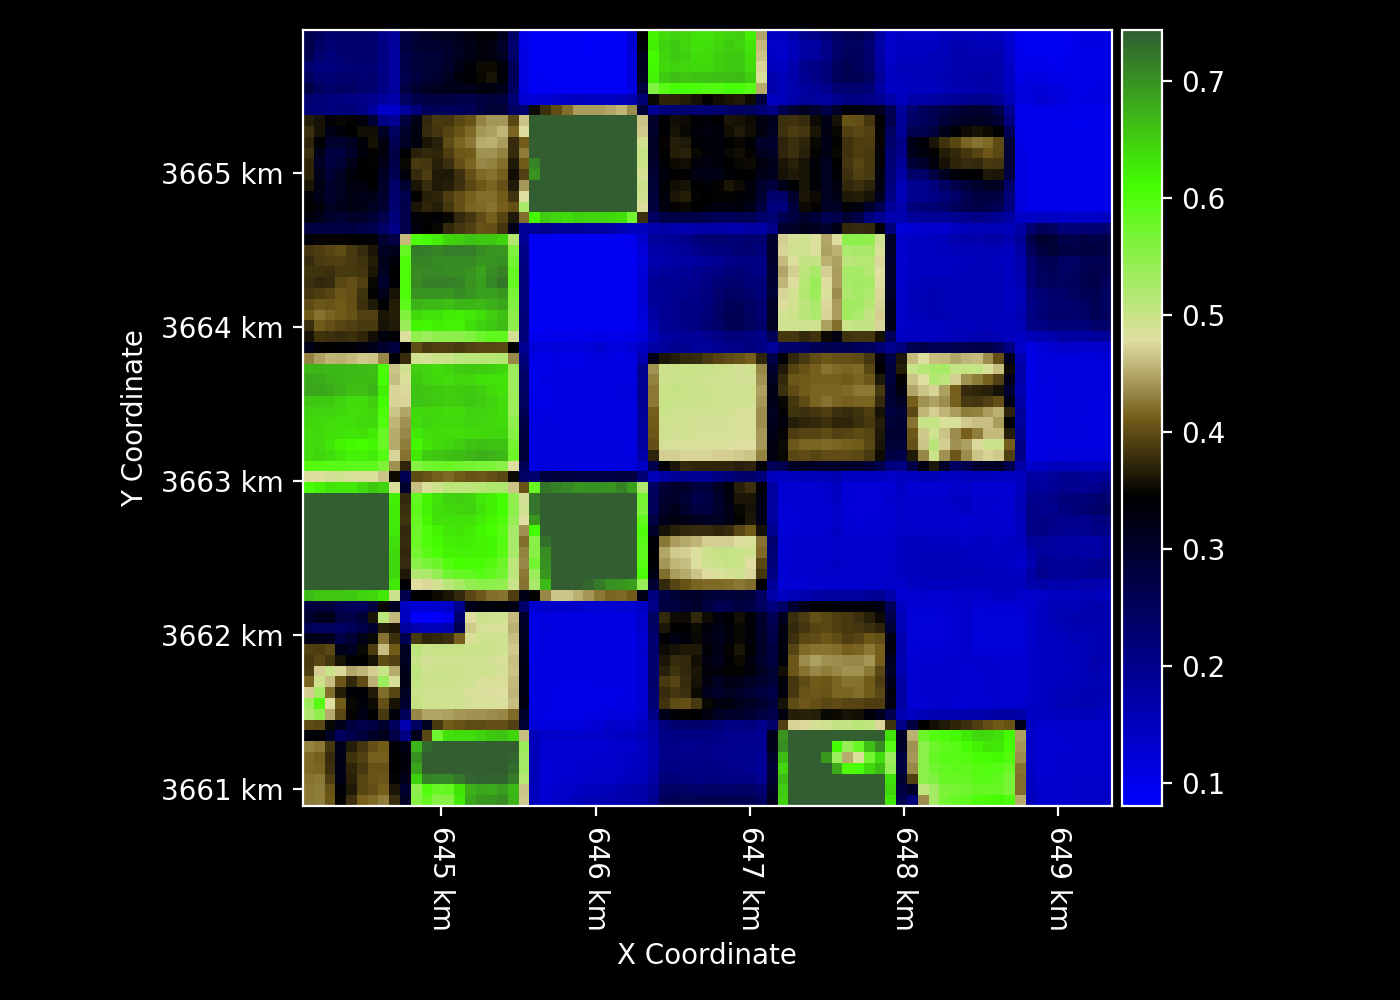

In [29]:
shifted_NDVI_tile = rt.Raster(NDVI_tile, geometry=shifted_tile_geometry)
shifted_NDVI = shifted_NDVI_tile.to_geometry(geometry, resampling="linear")
shifted_NDVI.cmap = NDVI_COLORMAP
shifted_NDVI

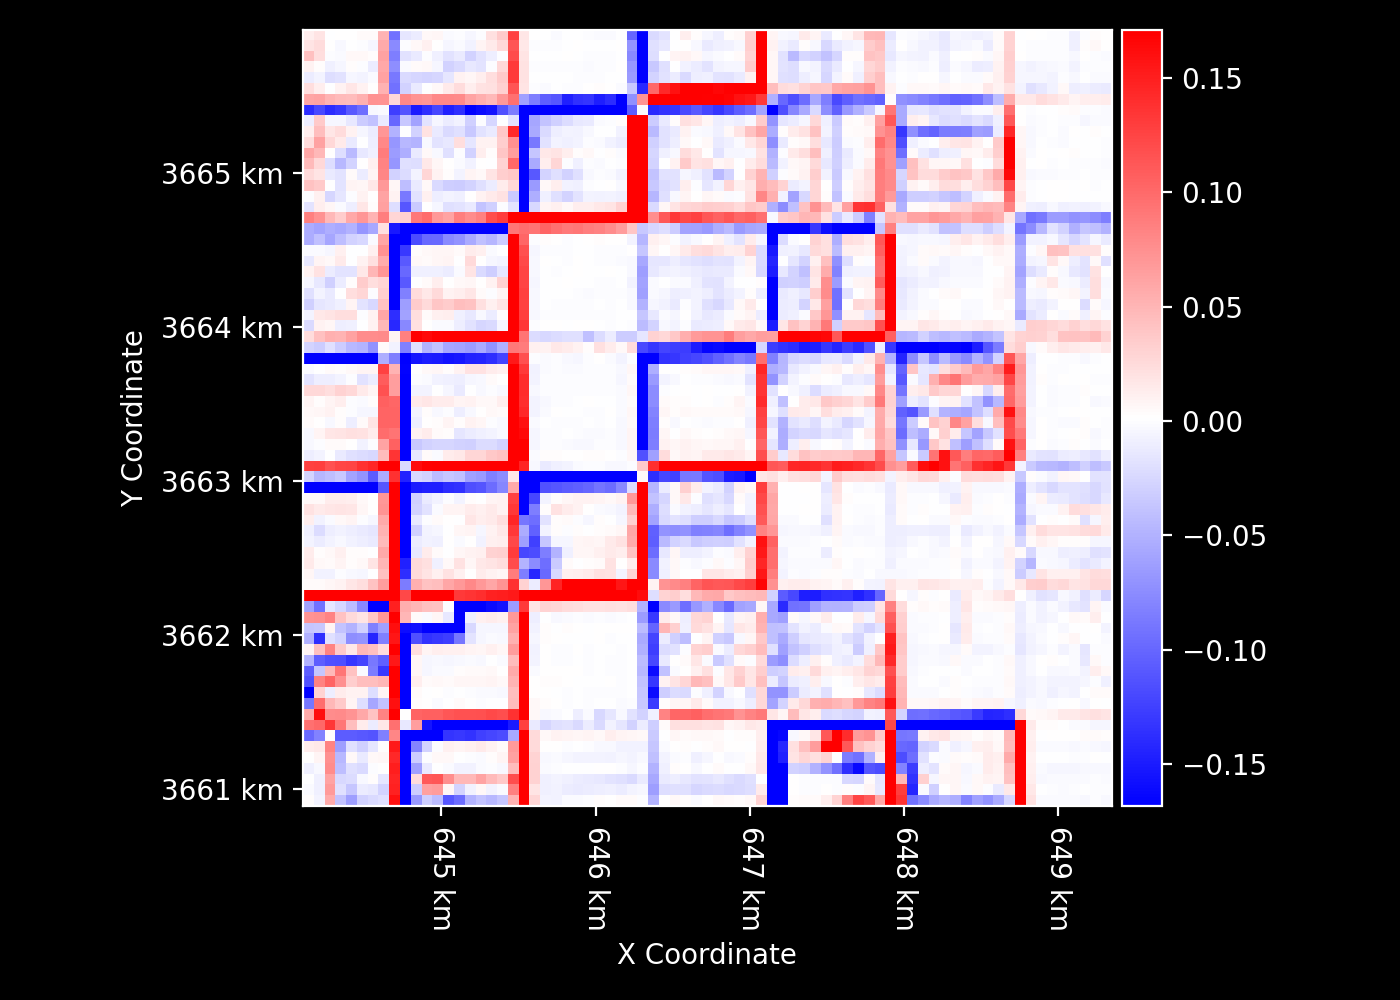

In [30]:
NDVI_error = shifted_NDVI - NDVI
NDVI_error.cmap = error_cmap
NDVI_error

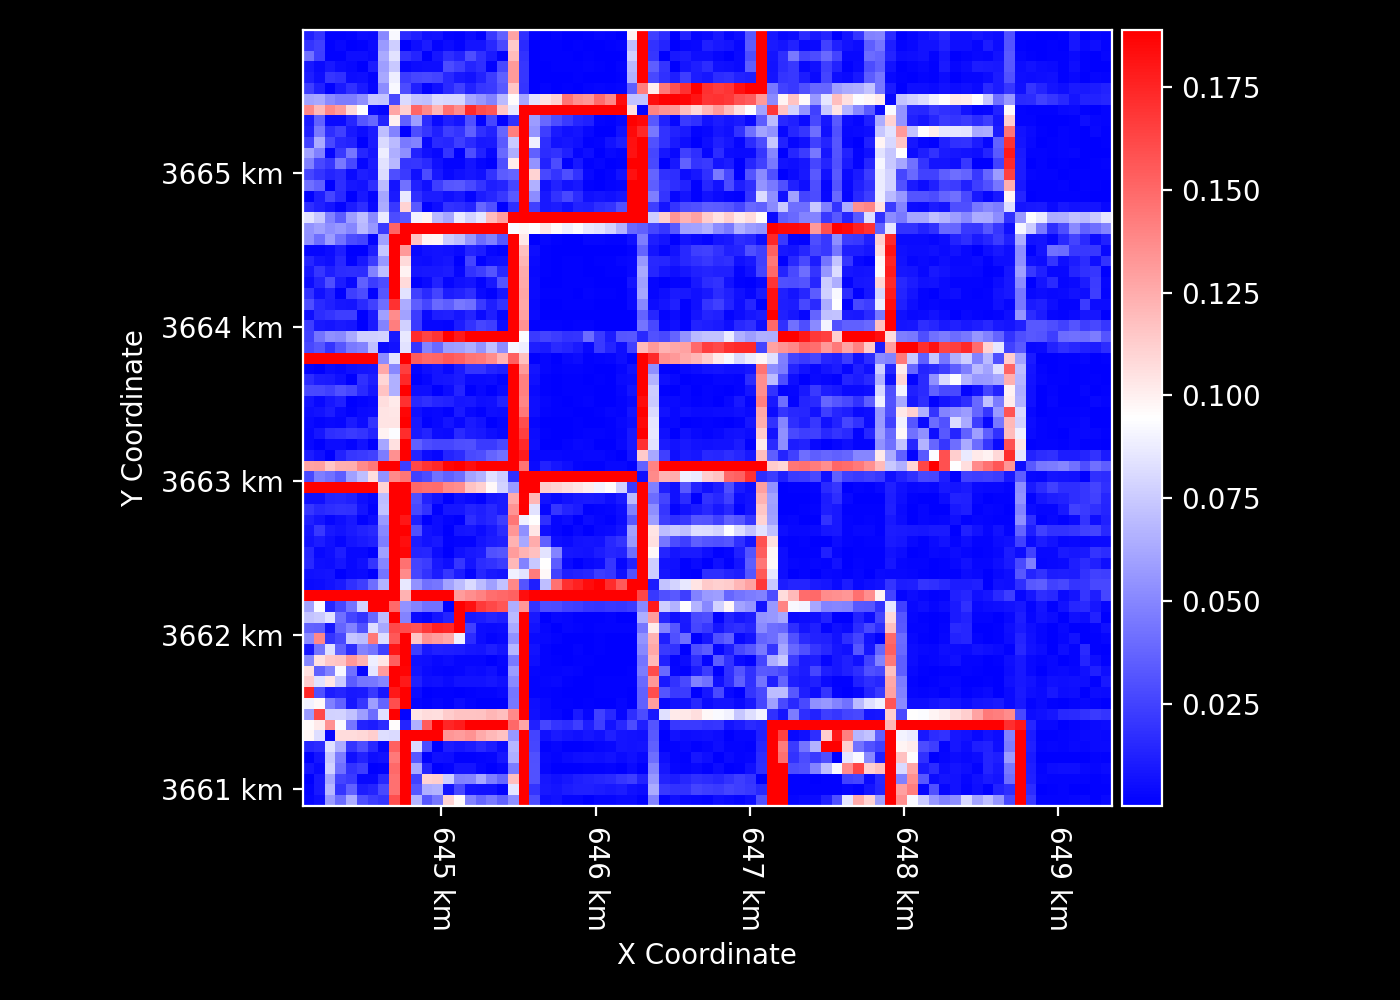

In [31]:
NDVI_abs_error = np.abs(shifted_NDVI - NDVI)
NDVI_abs_error.cmap = error_cmap
NDVI_abs_error

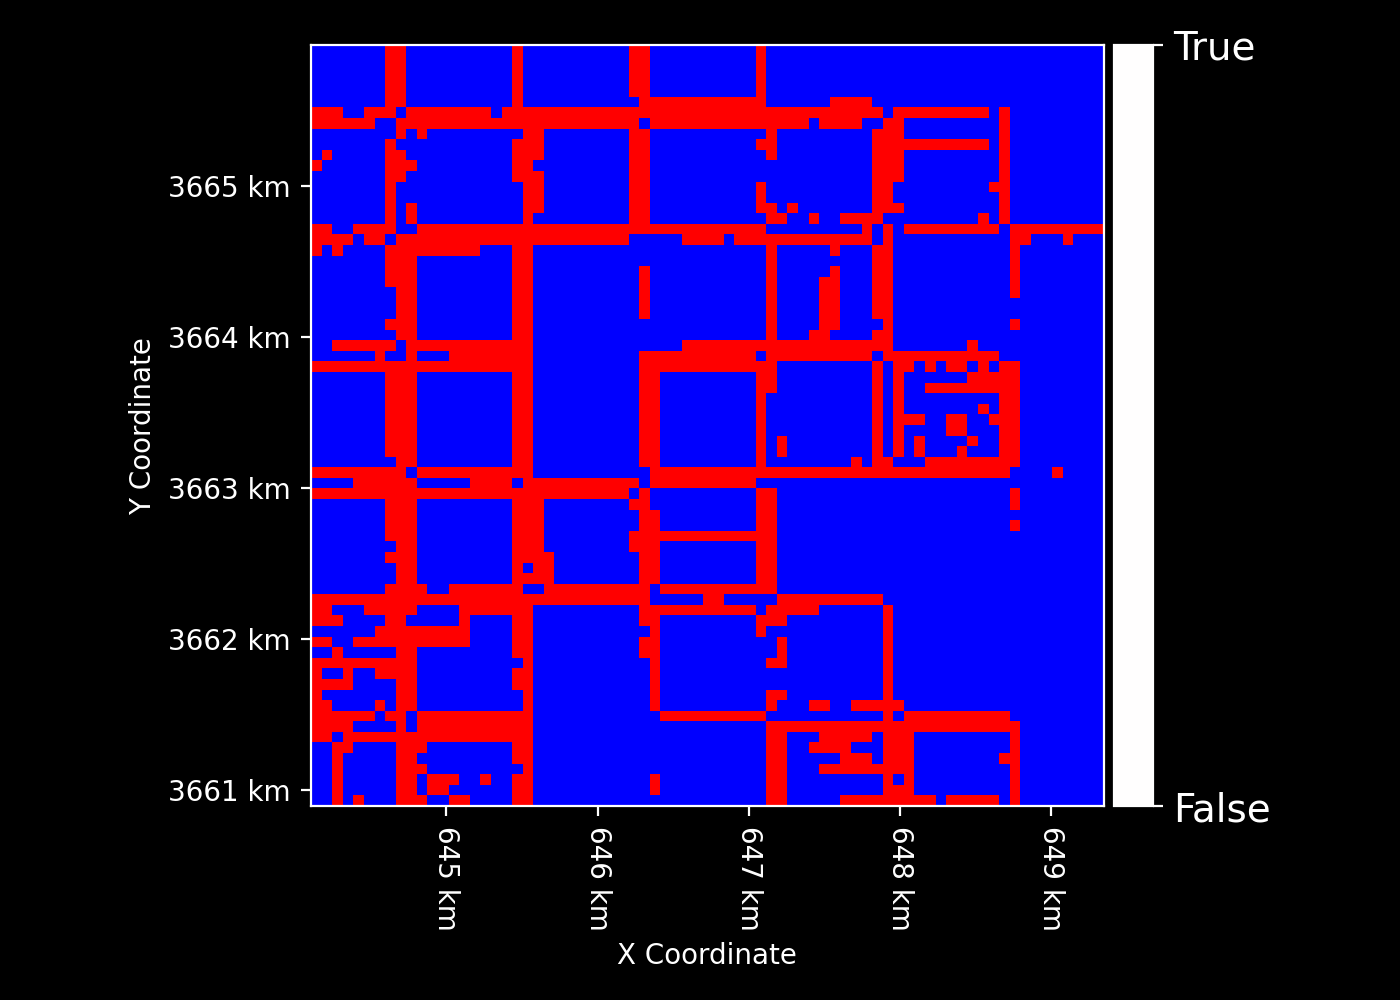

In [32]:
NDVI_abs_error > 0.05 ### use 0.05 as a segmentation threshold

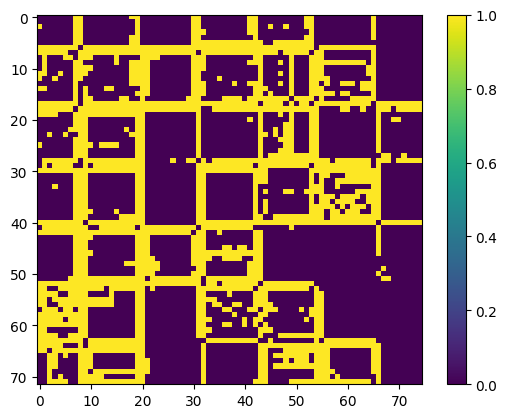

In [33]:
from sklearn.mixture import GaussianMixture
X = np.array(NDVI_abs_error).reshape(np.prod(NDVI_error.shape),1)
gm = GaussianMixture(n_components=2, random_state=0).fit(X)
clss = gm.predict(X)
plt.imshow(clss.reshape(NDVI_error.shape))
plt.colorbar()

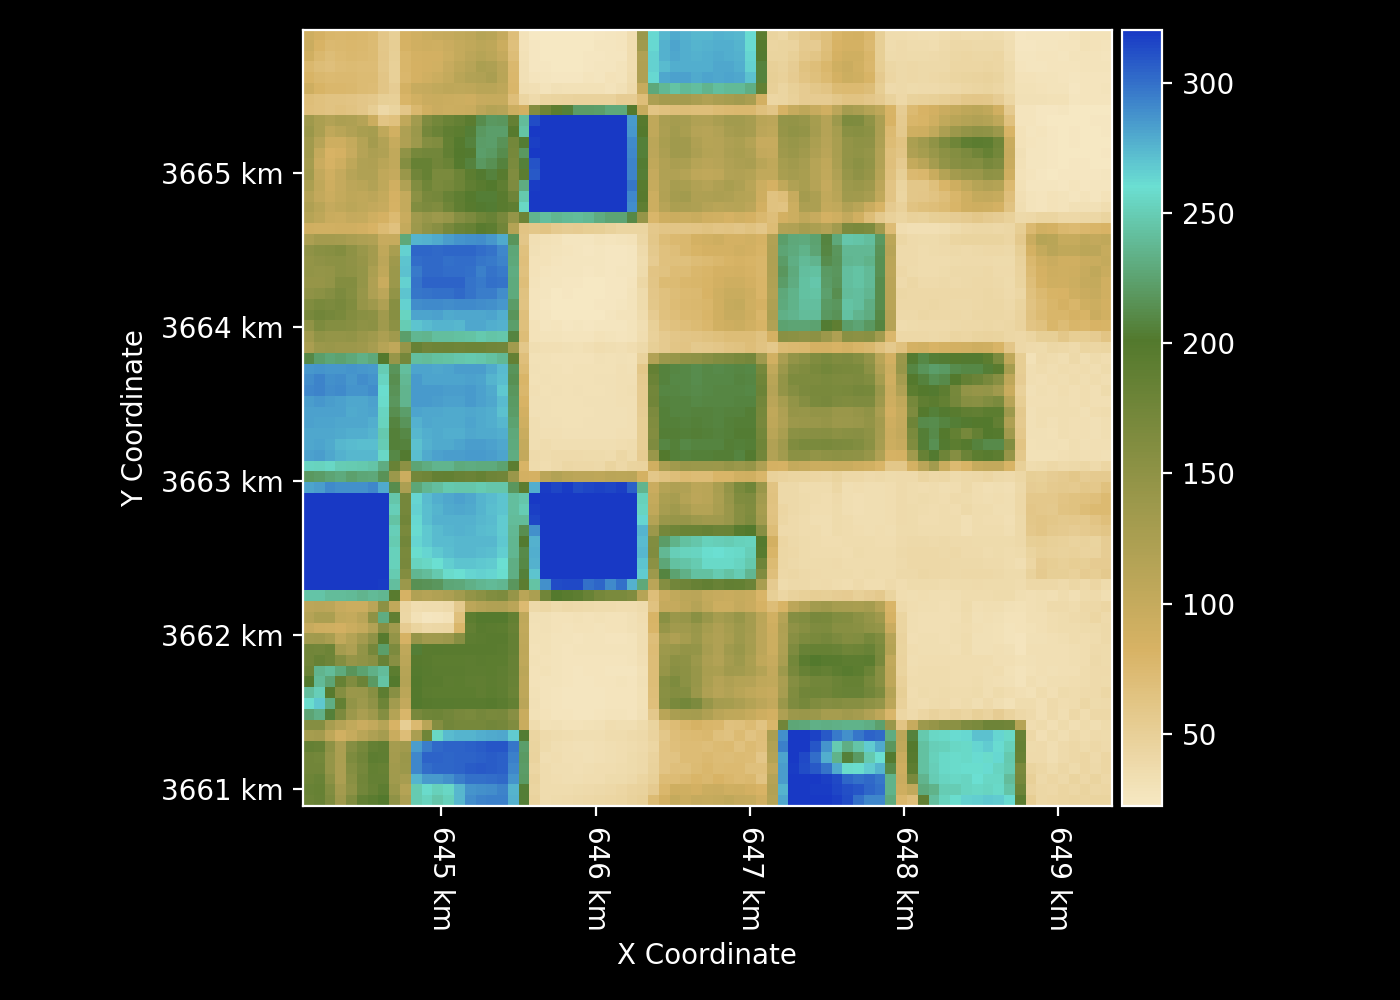

In [34]:
shifted_results = PTJPL(
    NDVI=shifted_NDVI,
    Ta_C=Ta_C,
    RH=RH,
    Rn=Rn,
    albedo=albedo,
    ST_C=ST_C
)

shifted_LE = shifted_results["LE"]
shifted_LE.cmap = ET_COLORMAP
shifted_LE

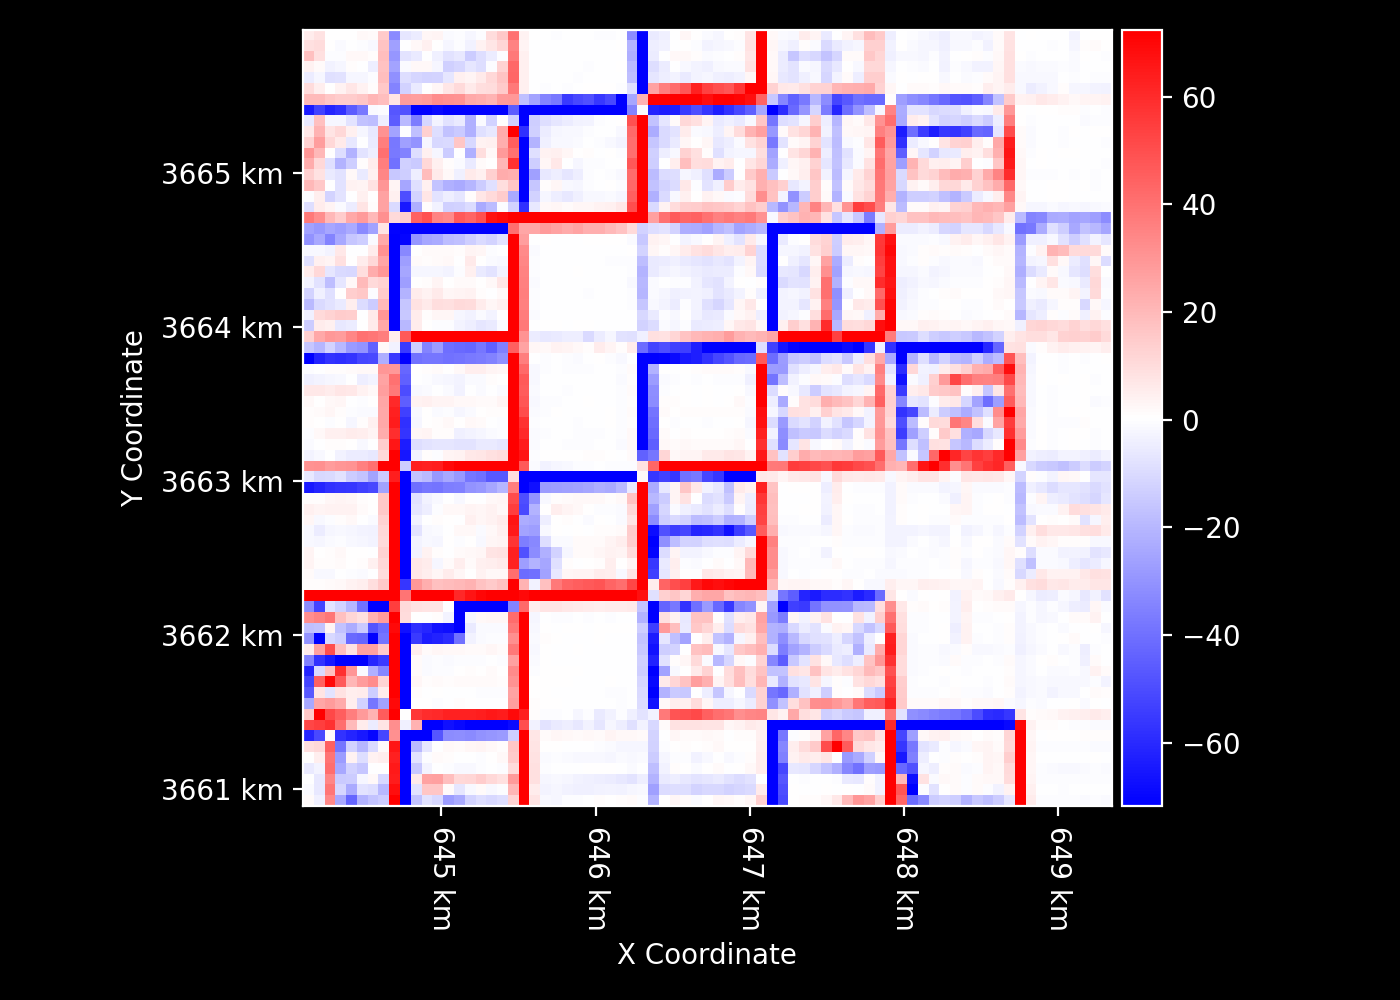

In [35]:
LE_error = shifted_LE - LE
LE_error.cmap = error_cmap
LE_error

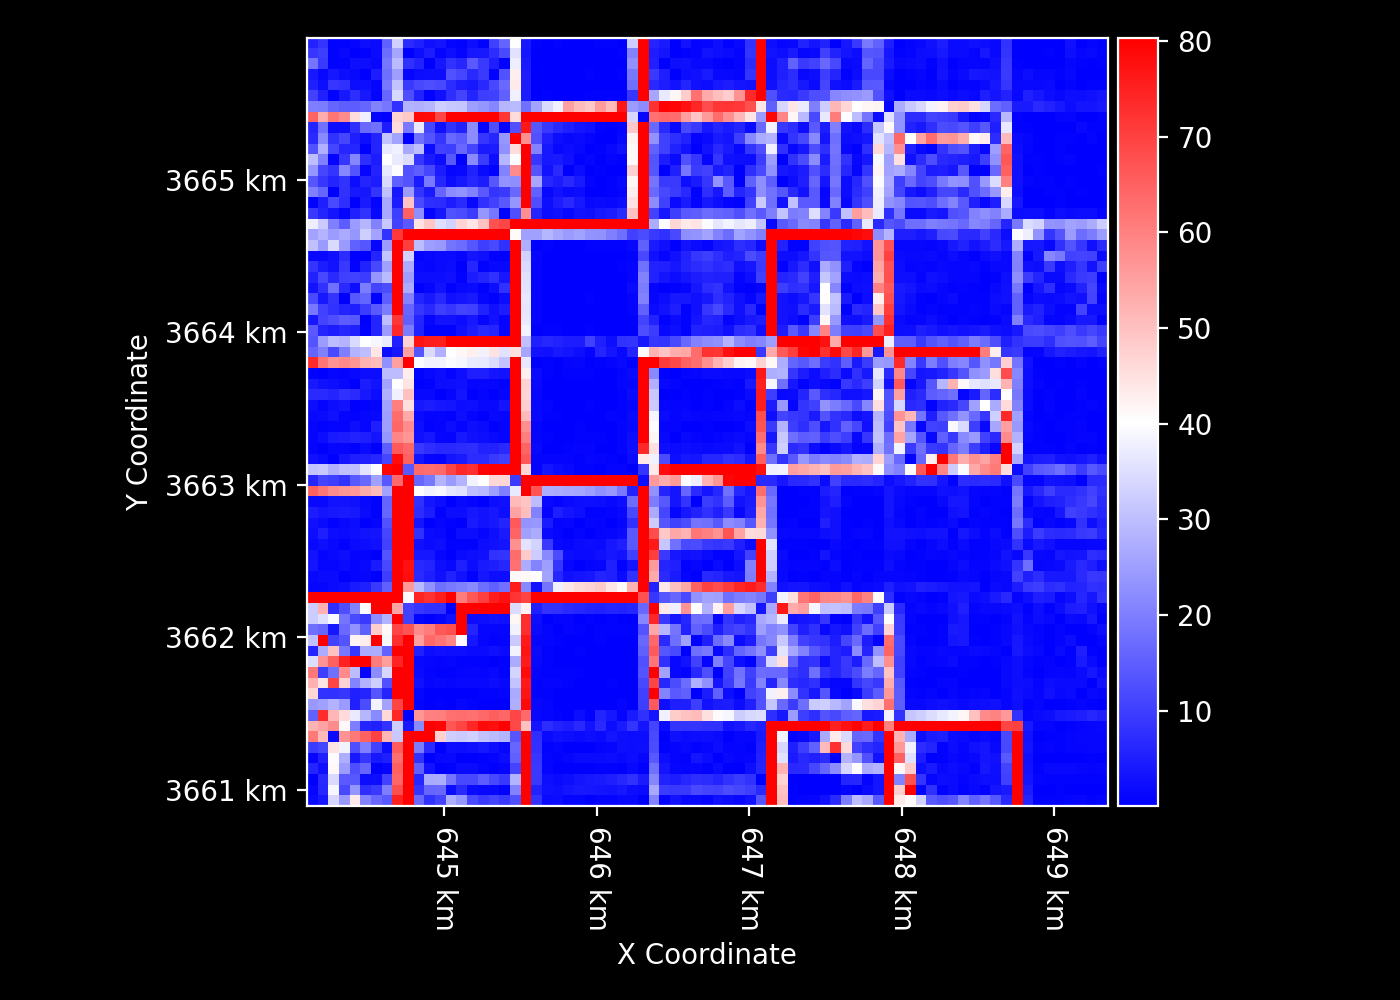

In [36]:
LE_abs_error = np.abs(shifted_LE - LE)
LE_abs_error.cmap = error_cmap
LE_abs_error

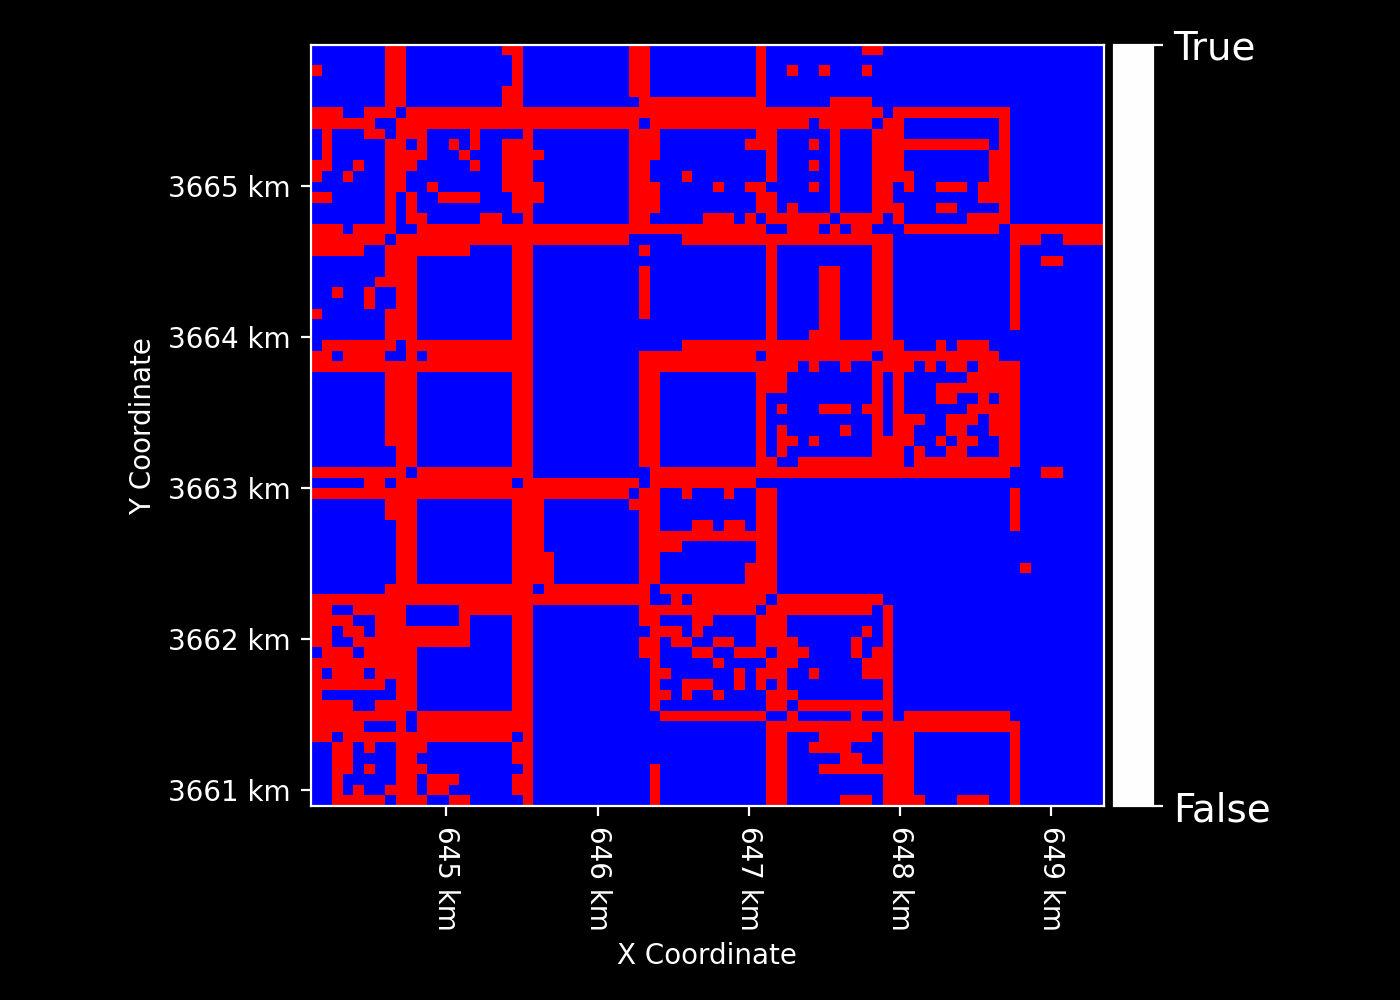

In [37]:
LE_abs_error > 15 ## 15 W/m^2

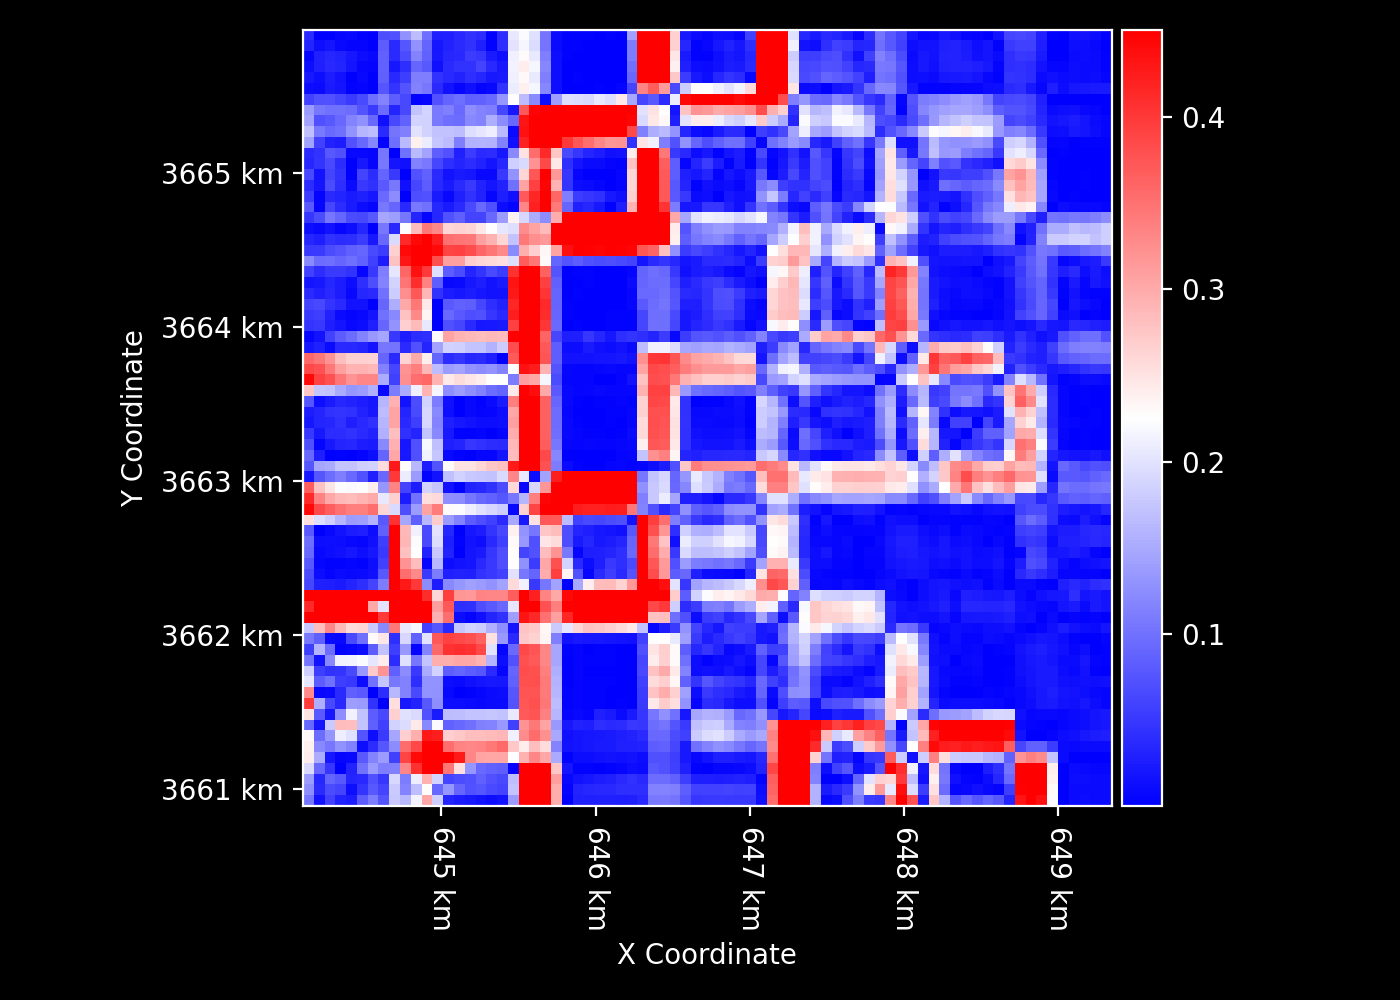

In [86]:
shifted_tile_geometry = tile_geometry.shift_distance(350, 45)
shifted_NDVI_tile = rt.Raster(NDVI_tile, geometry=shifted_tile_geometry)
shifted_NDVI = shifted_NDVI_tile.to_geometry(geometry, resampling="linear")
shifted_NDVI.cmap = NDVI_COLORMAP

NDVI_abs_error = np.abs(shifted_NDVI - NDVI)
NDVI_abs_error.cmap = error_cmap
NDVI_abs_error ### use 0.05 as a segmentation threshold

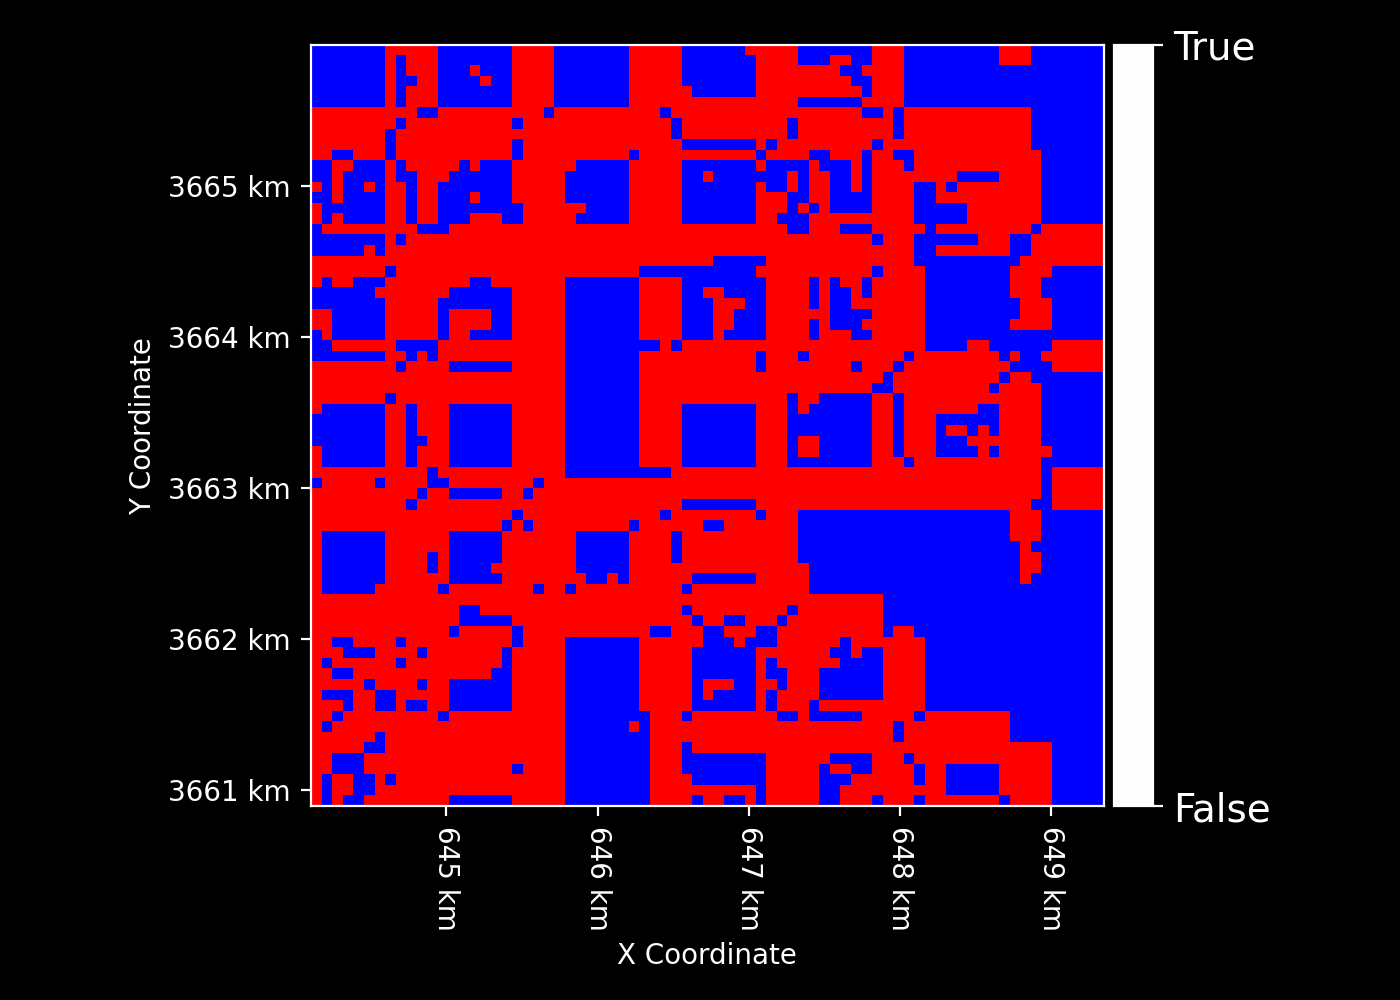

In [87]:
NDVI_abs_error > 0.05

In [38]:
n=200

In [39]:
directions = np.random.uniform(0, 360, n)
# directions

In [40]:
min_distance = 0
max_distance = 5 * 70
min_distance, max_distance

(0, 350)

In [41]:
distances = np.random.uniform(min_distance, max_distance, n)
# distances

In [68]:
ng = np.sqrt(1 - 0.8**2) ## acceptable ET error

In [55]:
df = pd.DataFrame({
    "distance": [],
    "direction": [],
    "NDVI_error": [],
    "LE_error": [],
    "NDVI": [],
    "LE": []
})

for distance, direction in zip(distances, directions):
    shifted_tile_geometry = tile_geometry.shift_distance(distance, direction)
    shifted_NDVI_tile = rt.Raster(NDVI_tile, geometry=shifted_tile_geometry)
    shifted_NDVI = shifted_NDVI_tile.to_geometry(geometry, resampling="linear")

    NDVI_error = shifted_NDVI - NDVI
    
    shifted_results = PTJPL(
        NDVI=shifted_NDVI,
        Ta_C=Ta_C,
        RH=RH,
        Rn=Rn,
        albedo=albedo,
        ST_C=ST_C
    )

    shifted_LE = shifted_results["LE"]
    LE_error = shifted_LE - LE

    ## add field boarder errors
    ## number of pixels with large errors
    kp = np.abs(NDVI_error) > 0.05
    np_large = np.sum(kp)

    # df = pd.concat([df, pd.DataFrame({
    #     "distance": distance,
    #     "direction": direction,
    #     "NDVI_error": NDVI_error.flatten(),
    #     "LE_error": LE_error.flatten(),
    #     "NDVI": NDVI.flatten(),
    #     "LE": LE.flatten()
    # })])

    df = pd.concat([df, pd.DataFrame({
        "distance": [distance],
        "direction": [direction],
        "num_higherror": [np_large],
        "NDVI_error": [np.nanmean(np.abs(NDVI_error))],
        "NDVI_hetero_error": [np.nanmean(np.abs(NDVI_error[kp]))],
        "NDVI_homo_error": [np.nanmean(np.abs(NDVI_error[~kp]))],
        "LE_error": [np.nanmean(np.abs(LE_error))],
        "LE_hetero_error": [np.nanmean(np.abs(LE_error[kp]))],
        "LE_homo_error": [np.nanmean(np.abs(LE_error[~kp]))],
        "NDVI": [np.nanmean(NDVI)],
        "LE": [np.nanmean(LE)]
    })])

df

/var/folders/mn/p7nlmtw91vz64gy8rcrtrpgm0000gq/T/ipykernel_12022/2766068392.py:48: RuntimeWarning: Mean of empty slice
  "NDVI_hetero_error": [np.nanmean(np.abs(NDVI_error[kp]))],
/var/folders/mn/p7nlmtw91vz64gy8rcrtrpgm0000gq/T/ipykernel_12022/2766068392.py:51: RuntimeWarning: Mean of empty slice
  "LE_hetero_error": [np.nanmean(np.abs(LE_error[kp]))],
/var/folders/mn/p7nlmtw91vz64gy8rcrtrpgm0000gq/T/ipykernel_12022/2766068392.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({
/var/folders/mn/p7nlmtw91vz64gy8rcrtrpgm0000gq/T/ipykernel_12022/2766068392.py:48: RuntimeWarning: Mean of empty slice
  "NDVI_hetero_error": [np.nanmean(np.abs(NDVI_error[kp]))],
/var/folders/mn/p7nlmtw91vz64gy8rcrtrpgm0000gq/T/i

,distance,direction,NDVI_error,LE_error,NDVI,LE,num_higherror,NDVI_hetero_error,NDVI_homo_error,LE_hetero_error,LE_homo_error
0,2.259397,52.741658,0.001506,0.572265,0.335572,130.636352,0.0,NaN,0.001506,NaN,0.572265
0,171.289398,30.249149,0.086662,35.630020,0.335572,130.636352,2193.0,0.191506,0.014968,79.052247,5.937179
0,302.597286,193.857873,0.120614,49.526661,0.335572,130.636352,2757.0,0.220206,0.016727,90.915678,6.352420
0,15.465032,344.087015,0.008979,3.584823,0.335572,130.636352,215.0,0.073033,0.006323,28.214162,2.563549
0,278.066853,273.450074,0.106137,43.458520,0.335572,130.636352,2521.0,0.208474,0.016525,85.855514,6.333538
...,...,...,...,...,...,...,...,...,...,...,...
0,325.997736,22.396842,0.129089,52.564737,0.335572,130.636352,2992.0,0.218883,0.017518,89.389234,6.809382
0,32.381582,153.423913,0.019743,7.934818,0.335572,130.636352,637.0,0.096926,0.009421,38.390610,3.861683
0,259.716225,226.165403,0.114163,47.058271,0.335572,130.636352,2729.0,0.209570,0.016683,86.885280,6.366429
0,317.875969,257.134728,0.122218,50.399562,0.335572,130.636352,2835.0,0.217076,0.017375,90.092494,6.528428


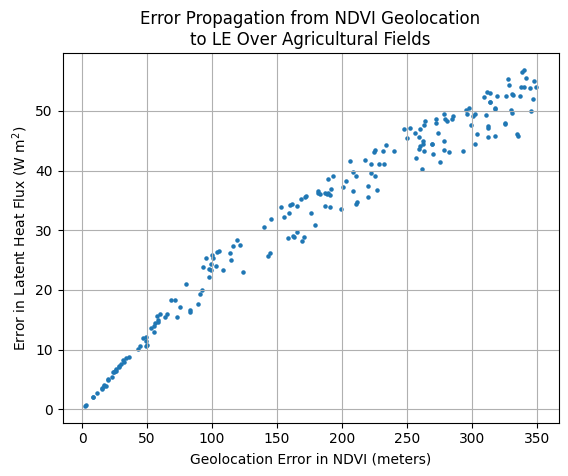

In [116]:
plt.scatter(x=df.distance, y=df.LE_error, s=5)
plt.xlabel('Geolocation Error in NDVI (meters)')
plt.ylabel('Error in Latent Heat Flux (W m$^2$)')
plt.title("Error Propagation from NDVI Geolocation\nto LE Over Agricultural Fields")
plt.grid(True)

plt.savefig("Error Propagation from NDVI Geolocation to PT-JPL Latent Heat Flux Over Agricultural Fields.png", bbox_inches="tight")

plt.show()

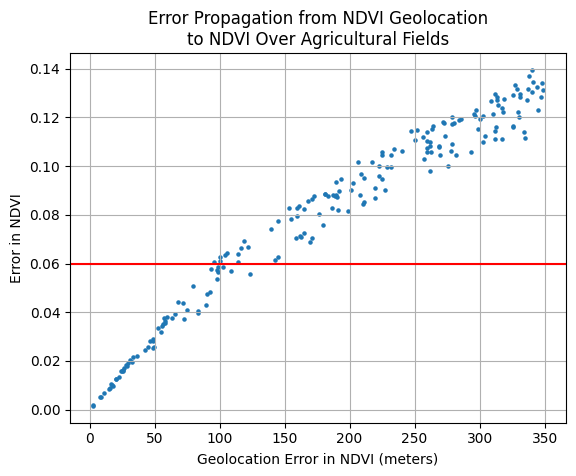

In [105]:
ndvi_errorcutoff = np.sqrt(0.1**2 - 0.08**2)

plt.scatter(x=df.distance, y=df.NDVI_error, s=5)
plt.axhline(y=ndvi_errorcutoff, color='red', linestyle='-')

plt.xlabel('Geolocation Error in NDVI (meters)')
plt.ylabel('Error in NDVI')
plt.title("Error Propagation from NDVI Geolocation\nto NDVI Over Agricultural Fields")
plt.grid(True)

# plt.savefig("Error Propagation from NDVI Geolocation to NDVI Over Agricultural Fields.png", bbox_inches="tight")

plt.show()

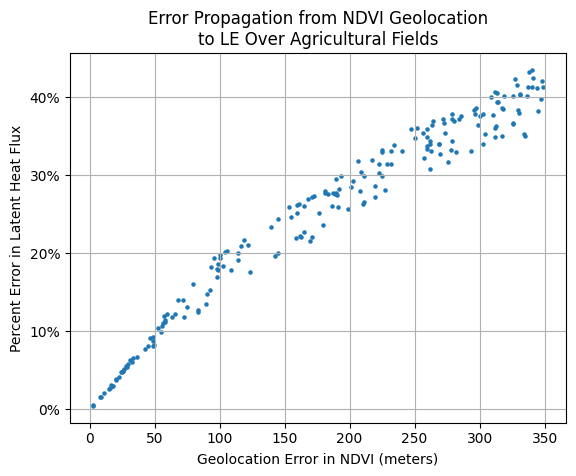

In [115]:
plt.scatter(x=df.distance, y=(df.LE_error / df.LE * 100), s=5)
plt.xlabel('Geolocation Error in NDVI (meters)')
plt.ylabel('Percent Error in Latent Heat Flux')
plt.title("Error Propagation from NDVI Geolocation\nto LE Over Agricultural Fields")
plt.grid(True)

# Function to format y-axis labels with percent sign
def percent_formatter(x, pos):
    return f'{x:.0f}%'

plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

plt.savefig("Error Propagation from NDVI Geolocation to PT-JPL Latent Heat Flux Over Agricultural Fields.png", bbox_inches="tight")

plt.show()

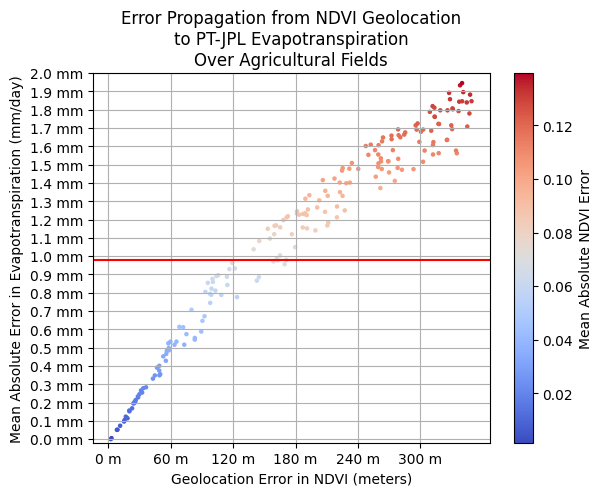

In [117]:
scatter = plt.scatter(x=df.distance, y=df.LE_error / 28.94, c=df.NDVI_error, s=5, cmap='coolwarm')
plt.xlabel('Geolocation Error in NDVI (meters)')
plt.ylabel('Mean Absolute Error in Evapotranspiration (mm/day)')
plt.title("Error Propagation from NDVI Geolocation\nto PT-JPL Evapotranspiration\nOver Agricultural Fields")
plt.grid(True)

# Set y-axis ticks interval to 0.1 and label them with "mm"
y_ticks = np.arange(min(df.LE_error / 28.94), max(df.LE_error / 28.94) + 0.1, 0.1)
plt.ylim(0, 2)
plt.yticks(y_ticks, [f'{tick:.1f} mm' for tick in y_ticks])

# Set x-axis ticks interval to 60 and format them as integers
x_ticks = np.arange(0, 360, 60)
plt.xticks(x_ticks, [f'{int(tick)} m' for tick in x_ticks])

# Add horizontal red lines at y=1 and y=-1
plt.axhline(y=1, color='red', linestyle='-')
plt.axhline(y=-1, color='red', linestyle='-')

# Show color bar legend
plt.colorbar(scatter, label='Mean Absolute NDVI Error')

plt.savefig("Error Propagation from NDVI Geolocation to PT-JPL Evapotranspiration Over Agricultural Fields.png", bbox_inches="tight")

plt.show()

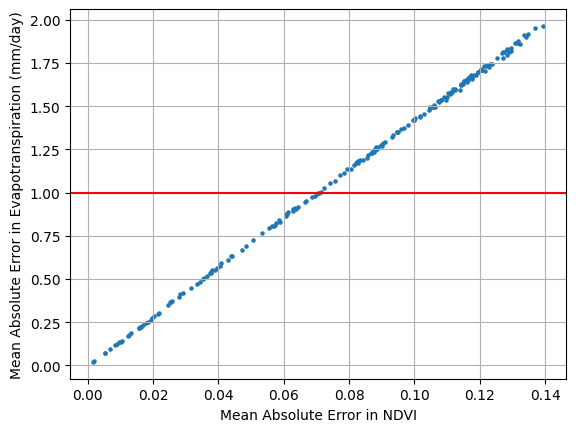

In [70]:
scatter = plt.scatter(x=df.NDVI_error, y=df.LE_error / 28.94, s=5)
plt.xlabel('Mean Absolute Error in NDVI')
plt.ylabel('Mean Absolute Error in Evapotranspiration (mm/day)')
plt.grid(True)

# Add a horizontal red line at y=1
plt.axhline(y=1, color='red', linestyle='-')

plt.show()

In [71]:
np.nanmean((df.LE_error / 28.94) / df.NDVI_error)

14.156471399376157

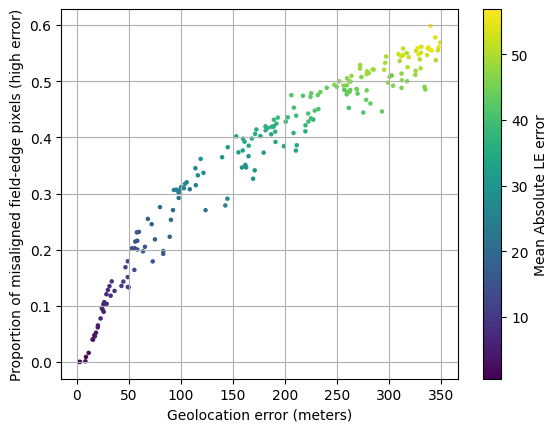

In [72]:
nps = np.prod(NDVI_error.shape)
plt.scatter(x=df.distance, y=df.num_higherror/nps, c=df.LE_error,s=5)
plt.colorbar(label='Mean Absolute LE error')
plt.xlabel('Geolocation error (meters)')
plt.ylabel('Proportion of misaligned field-edge pixels (high error)')
plt.grid(True)
plt.show()

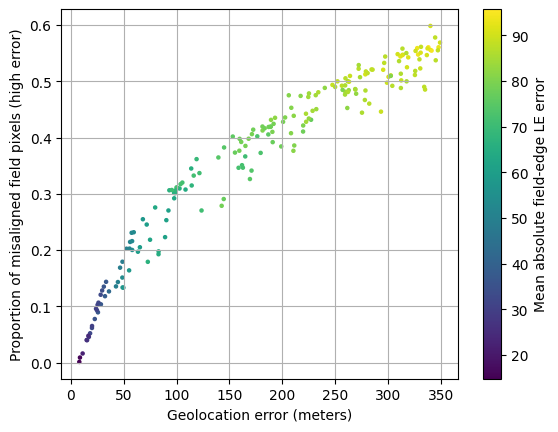

In [ ]:
nps = np.prod(NDVI_error.shape)
plt.scatter(x=df.distance, y=df.num_higherror/nps, c=df.LE_hetero_error,s=5)
plt.colorbar(label='Mean absolute field-edge LE error')
plt.xlabel('Geolocation error (meters)')
plt.ylabel('Proportion of misaligned field pixels (high error)')
plt.grid(True)

plt.show()

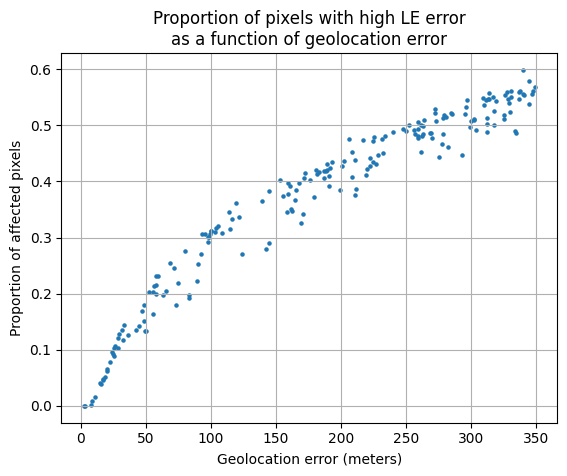

In [111]:
nps = np.prod(NDVI_error.shape)
plt.scatter(x=df.distance, y=df.num_higherror/nps,s=5)
plt.xlabel('Geolocation error (meters)')
plt.ylabel('Proportion of affected pixels')
plt.title('Proportion of pixels with high LE error\nas a function of geolocation error')
plt.grid(True)
plt.savefig("Proportion of high error pixels.png", bbox_inches="tight")

plt.show()
## farms here are roughly 10x10 pixels, so 5 pixel shift corresponding to roughly 50% of fields contaminated makes sense

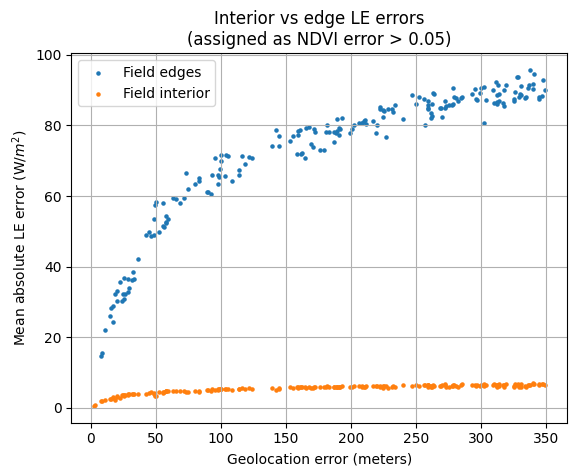

In [ ]:
nps = np.prod(NDVI_error.shape)
plt.scatter(x=df.distance, y=df.LE_hetero_error, s=5, label="Field edges")
plt.scatter(x=df.distance, y=df.LE_homo_error, s=5, label="Field interior")
plt.legend()
# plt.axhline(y=np.sqrt((1-0.75**2))*28.94, c='red',linestyle='-', label="0.75 mm/day error")
# plt.axhline(y=np.sqrt((1-0.75**2))*100.94, c='red',linestyle='-', label="0.75 mm/day error")
plt.xlabel('Geolocation error (meters)')
plt.ylabel('Mean absolute LE error (W/$m^2$)')
plt.title('Interior vs edge LE errors\n(assigned as NDVI error > 0.05)')
plt.grid(True)
plt.savefig("Interior vs edge of field LE errors.png", bbox_inches="tight")
plt.show()

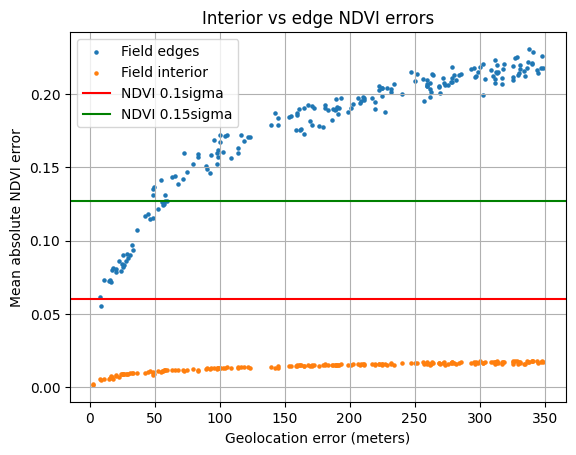

In [109]:
nps = np.prod(NDVI_error.shape)
plt.scatter(x=df.distance, y=df.NDVI_hetero_error, s=5, label="Field edges")
plt.scatter(x=df.distance, y=df.NDVI_homo_error, s=5, label="Field interior")
plt.axhline(y=ndvi_errorcutoff, c='red',linestyle='-', label="NDVI 0.1sigma")
plt.axhline(y=np.sqrt(0.15**2 - 0.08**2), c='green',linestyle='-', label="NDVI 0.15sigma")
plt.legend()
plt.xlabel('Geolocation error (meters)')
plt.ylabel('Mean absolute NDVI error')
plt.title('Interior vs edge NDVI errors')
plt.grid(True)
plt.savefig("Interior vs edge of field NDVI errors.png", bbox_inches="tight")
plt.show()